<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fraud Detection Competition**

В данном соревновании мы потренируемся применять навыки построения ML-пайплайнов, от EDA до построения и валидации ML-моделей 

## **Задача**
**Мы будем решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Нам нужно будет:**
- В jupyter notebook провести исследование данных;
- В нём же построить модели и оценить их качество;
- Отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

# **Базовое решение и пример формирования файла под submission**


In [1]:
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0': Scheme missing.
'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0': Scheme missing.
'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0': Scheme missing.
'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0': Scheme missing.
'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0': Scheme missing.


In [19]:
!pip install catboost -q

  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm

In [ ]:
INPUT_DIR = 'raw_data'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [179]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [5]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 143631.42it/s]


In [6]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, object_cols, )

Learning rate set to 0.5
0:	learn: 0.2082395	total: 349ms	remaining: 698ms
1:	learn: 0.1360790	total: 517ms	remaining: 258ms
2:	learn: 0.1180984	total: 720ms	remaining: 0us


In [7]:
predictions = cb.predict_proba(df_test.fillna(''))

In [8]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

,TransactionID,isFraud
0,3404559,0.978714
1,3404560,0.935724
2,3404561,0.946864
3,3404562,0.978714
4,3404563,0.970637


In [ ]:
# Сохранение submission
OUTPUT_DIR = 'outputs'

sub.to_csv(os.path.join(OUTPUT_DIR,'submission_baseline.csv', index=False))

### **Примечания:**

**Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных мы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у нас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.


# **1. EDA**

Проведем EDA:
* проанализируем признаки, их особенности и связь с целевой переменной
* проанализируем целевую переменную
* оценим степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделаем необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [10]:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)

In [25]:
# Возьмем информацию о датасете
print("TRAIN INFO")
df_train.info()
print("\nTEST INFO")
df_test.info()

TRAIN INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.3+ GB

TEST INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 431 entries, TransactionAmt to DeviceInfo
dtypes: float64(399), int64(1), object(31)
memory usage: 568.8+ MB


In [27]:
# Посмотрим на данные
print("\nTRAIN")
display(df_train.head())
print("\nTEST HEAD")
display(df_test.head())


TRAIN


,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,...,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,35


TEST HEAD


,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,...,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,311.95,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,4.0,NaN,gmail.com,NaN,185.0,168.0,0.0,0.0,126.0,110.0,0.0,0.0,144.0,0.0,143.0,0.0,522.0,142.0,131.0,131.0,1.0,592.0,1.0,NaN,NaN,NaN,NaN,482.0,579.0,NaN,NaN,NaN,592.0,T,T,T,NaN,NaN,T,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,509.799988,35.950001,0.0,509.799988,0.0,35.950001,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59.00,W,15497,490.0,150.0,visa,226.0,debit,299.0,87.0,227.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,1.0,5.0,1.0,27.0,27.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,27.0,21.0,NaN,NaN,NaN,27.0,T,T,T,M0,F,F,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,4.0,0.0,3.0,5.0,0.0,5.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,5.0,3.0,4.0,0.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,194.0,954.989990,408.000000,0.0,351.989990,0.0,117.000000,59.0,351.98999,151.0,194.0,442.0,291.0,0.0,161.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59.00,W,7919,194.0,150.0,mastercard,166.0,debit,325.0,87.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,F,M0,F,F,F,F,T,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,160.50,W,16075,514.0,150.0,mastercard,102.0,credit,123.0,87.0,4.0,NaN,yahoo.com,NaN,144.0,146.0,0.0,0.0,93.0,115.0,0.0,0.0,108.0,0.0,117.0,0.0,455.0,113.0,0.0,NaN,NaN,166.0,166.0,NaN,NaN,NaN,NaN,166.0,166.0,NaN,NaN,NaN,166.0,T,T,T,M0,T,F,F,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0

In [182]:
# посчитаем кол-во числовых и категориальных признаков
num_cols = df_train.drop(columns=['isFraud']).select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_train.drop(columns=['isFraud']).select_dtypes(exclude=[np.number]).columns.tolist()
print(f"\nЧисловых признаков: {len(num_cols)}")
print(f"Категориальных признаков: {len(cat_cols)}")


Числовых признаков: 400
Категориальных признаков: 31


## Распределения числовых признаков

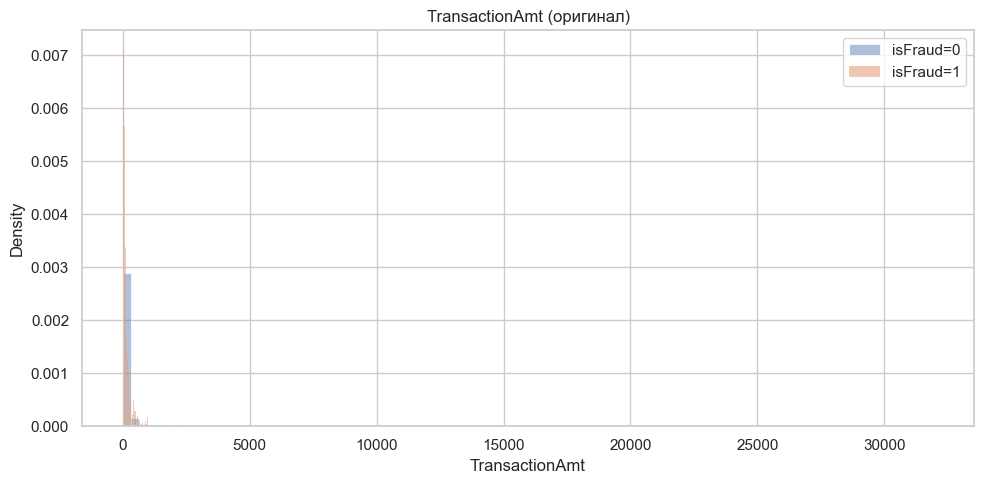

In [43]:
# TransactionAmt
amt_0 = df_train.loc[df_train['isFraud'] == 0, 'TransactionAmt'].astype(float)
amt_1 = df_train.loc[df_train['isFraud'] == 1, 'TransactionAmt'].astype(float)

plt.figure(figsize=(10, 5))
sns.histplot(amt_0, bins=100, stat='density', common_norm=False, alpha=0.45, label='isFraud=0')
sns.histplot(amt_1, bins=100, stat='density', common_norm=False, alpha=0.45, label='isFraud=1')
plt.title('TransactionAmt (оригинал)')
plt.xlabel('TransactionAmt')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

Распределение суммы транзакций очень скошено, для получения более понятной картины логарифмируем

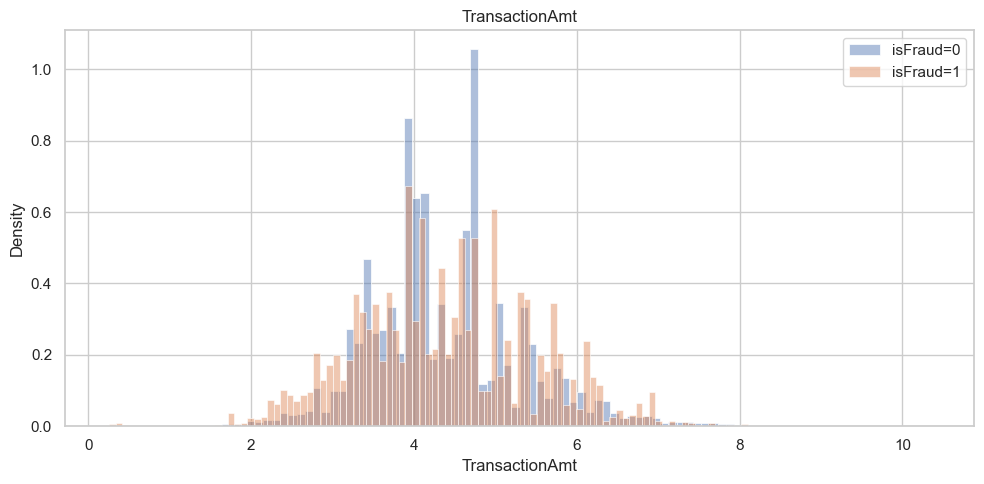

In [41]:
# Логарифмируем для более понятной картины
amt_0_log = np.log1p(amt_0.clip(lower=0).fillna(0))
amt_1_log = np.log1p(amt_1.clip(lower=0).fillna(0))

plt.figure(figsize=(10, 5))
sns.histplot(amt_0_log, bins=100, stat='density', common_norm=False, alpha=0.45, label='isFraud=0')
sns.histplot(amt_1_log, bins=100, stat='density', common_norm=False, alpha=0.45, label='isFraud=1')
plt.title('TransactionAmt')
plt.xlabel('TransactionAmt')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

После логарифмирования распределение становится ближе к нормальному, классы лучше различимы 

Мошеннические транзакции чаще сосредоточены в диапазоне средних и относительно небольших сумм

In [184]:
# Логарифмируем в датасете
df_train['TransactionAmt'] = np.log1p(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log1p(df_test['TransactionAmt'])

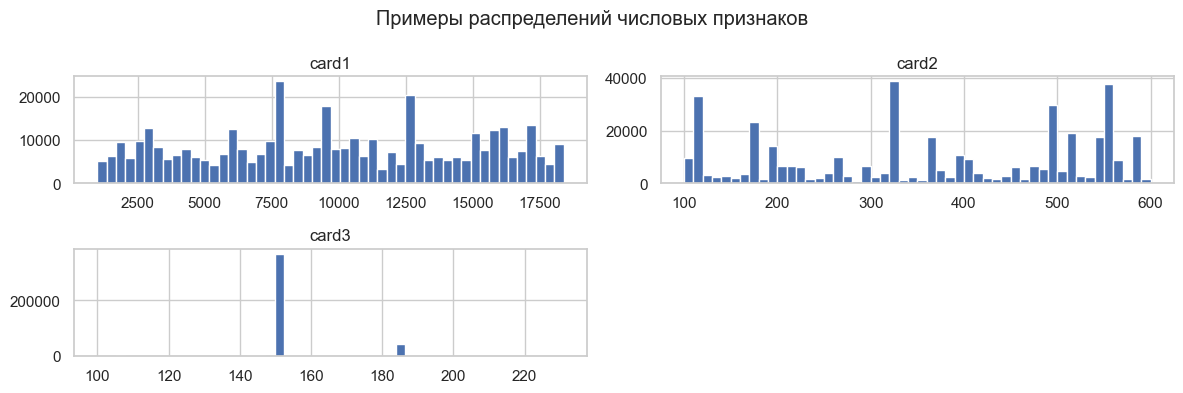

In [58]:
# Сделаем распределения с другими числовыми признаками
extra_num = [c for c in num_cols if c not in ['TransactionAmt']][:3]
if extra_num:
    df_train[extra_num].hist(figsize=(12, 4), bins=50)
    plt.suptitle("Примеры распределений числовых признаков")
    plt.tight_layout()
    plt.show()

Распределения крайне неоднородные, часто с выраженными «пиками» и дискретной структурой card3 имеет особенно сильную концентрацию в одном значении, что может быть индикатором важности признака 

Это подтверждает, что данные содержат закодированные категориальные или счётные признаки в числовом формате

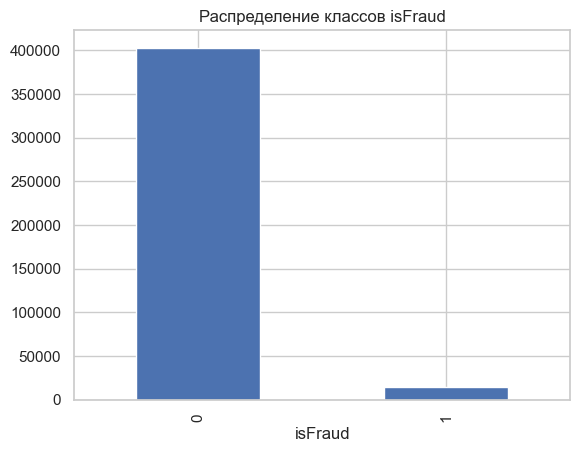

Доля мошеннических транзакций (train): 0.0353


In [52]:
# Выведем распределения классов для таргета
class_counts = df_train['isFraud'].value_counts()
ax = class_counts.plot(kind='bar', title='Распределение классов isFraud')
plt.show()
fraud_rate = df_train['isFraud'].mean()
print(f"Доля мошеннических транзакций (train): {fraud_rate:.4f}")

В таргете видим сильный дисбаланс классов (более 96.5% - не мошеннические и менее 3.5% - мошеннические)

## Посмотрим связи признаков в таргетом

isFraud,0,1
DeviceType,,
desktop,0.940112,0.059888
missing,0.978574,0.021426
mobile,0.901459,0.098541


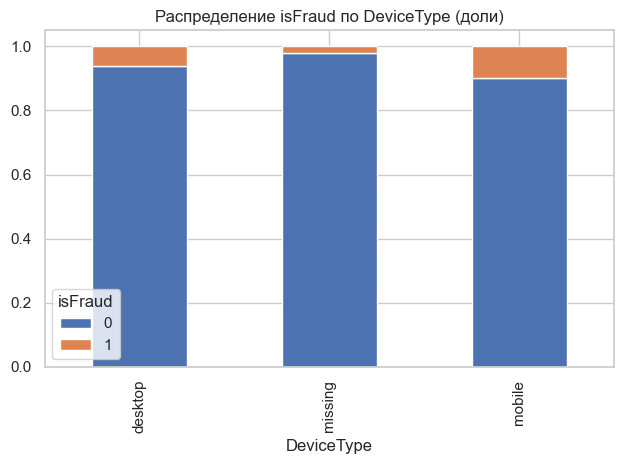

In [61]:
# Посмотрим связь типа устройства с мошенничеством
if 'DeviceType' in df_train.columns:
    ct = pd.crosstab(df_train['DeviceType'].fillna('missing'), df_train['isFraud'], normalize='index')
    display(ct)
    ct.plot(kind='bar', stacked=True, title='Распределение isFraud по DeviceType (доли)')
    plt.legend(title='isFraud')
    plt.tight_layout()
    plt.show()

По распределению видно, что устройство играет роль, причём мобильные транзакции чаще ассоциированы с мошенничеством (~10%)


Топ-10 комбинаций TLD по среднему isFraud:


PR_email_tld_combo
es_es              0.108202
com_com            0.084569
missing_com        0.064396
missing_missing    0.026571
com_missing        0.020543
mx_mx              0.017269
net_com            0.017163
net_net            0.014740
net_missing        0.012767
com_net            0.005867
Name: isFraud, dtype: float64

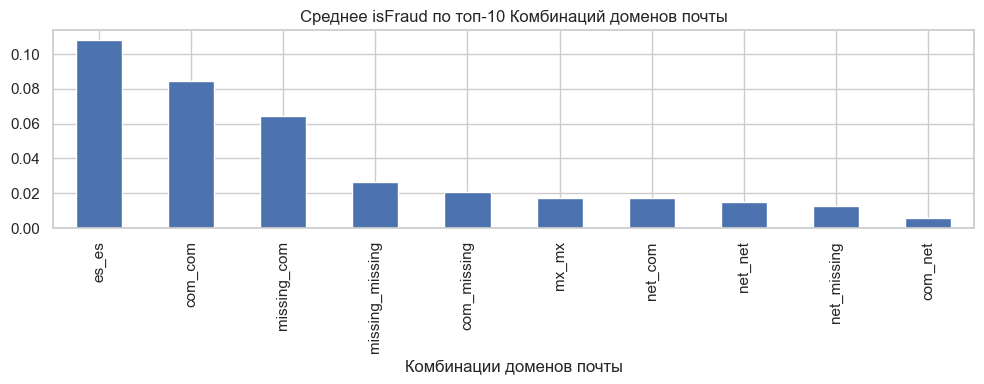

In [15]:
# Посмотрим связь комбинаций доменов с фродом

def extract_tld(s):
    if pd.isna(s): return 'missing'
    s = str(s).lower()
    parts = s.split('.')
    return parts[-1] if len(parts) >= 2 else s

for col in ['P_emaildomain', 'R_emaildomain']:
    if col in df_train.columns:
        df_train[col + '_tld'] = df_train[col].apply(extract_tld)
        df_test[col + '_tld'] = df_test[col].apply(extract_tld)
    else:
        df_train[col + '_tld'] = 'missing'
        df_test[col + '_tld'] = 'missing'

df_train['PR_email_tld_combo'] = df_train['P_emaildomain_tld'].astype(str) + "_" + df_train['R_emaildomain_tld'].astype(str)
df_test['PR_email_tld_combo']  = df_test['P_emaildomain_tld'].astype(str)  + "_" + df_test['R_emaildomain_tld'].astype(str)

top_combos = df_train['PR_email_tld_combo'].value_counts().head(10).index
tmp = (df_train[df_train['PR_email_tld_combo'].isin(top_combos)]
       .groupby('PR_email_tld_combo')['isFraud'].mean()
       .sort_values(ascending=False))
print("\nТоп-10 комбинаций TLD по среднему isFraud:")
display(tmp)

plt.figure(figsize=(10,4))
tmp.plot(kind='bar')
plt.title('Среднее isFraud по топ-10 Комбинаций доменов почты')
plt.xlabel('Комбинации доменов почты')
plt.tight_layout()
plt.show()

Видим, что комбинации доменов es_es и com_com имеют высокую среднюю долю мошенничества (10% и 8%), а так же комбинации, где нет почты

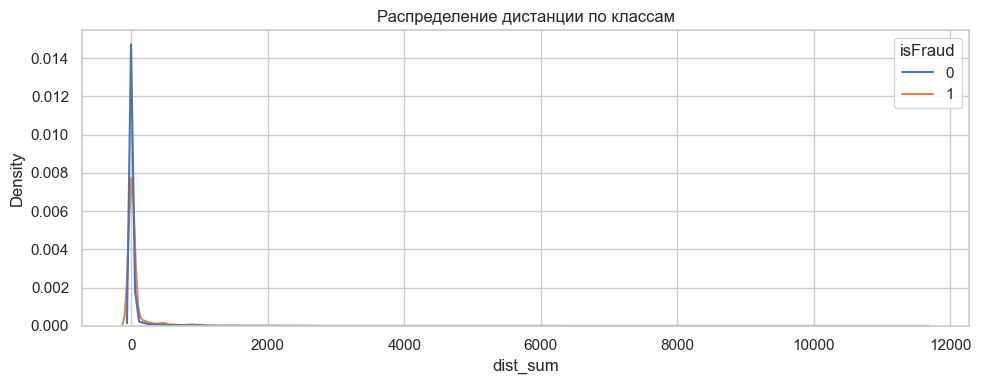

In [17]:
# Посмотрим связь расстояния с таргетом

for col in ['dist1','dist2']:
    if col not in df_train.columns:
        df_train[col] = np.nan
        df_test[col] = np.nan

df_train['dist_sum'] = df_train[['dist1','dist2']].sum(axis=1, skipna=True)
df_test['dist_sum']  = df_test[['dist1','dist2']].sum(axis=1,  skipna=True)

plt.figure(figsize=(10,4))
sns.kdeplot(data=df_train, x='dist_sum', hue='isFraud', common_norm=False)
plt.title('Распределение дистанции по классам')
plt.tight_layout()
plt.show()

Не очень информативно, попробуем логарифмировать,

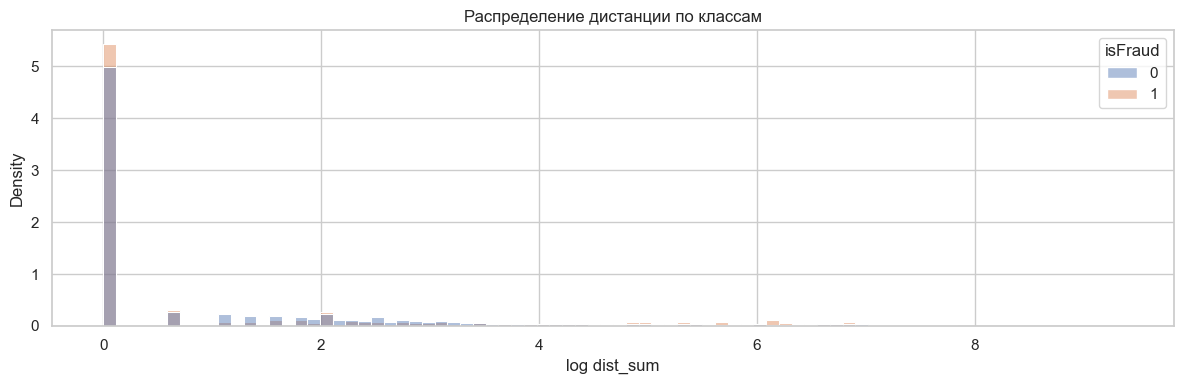

In [18]:
# Сделаем в лог-масштабе

plt.figure(figsize=(12,4))
sns.histplot(
    data=df_train,
    x=np.log1p(df_train['dist_sum'].fillna(0)),
    hue='isFraud',
    bins=80, stat='density', common_norm=False, alpha=0.45
)
plt.title('Распределение дистанции по классам')
plt.xlabel('log dist_sum')
plt.tight_layout()
plt.show()

Классы более раличимы и видно, что мошеннические транзакции чуть более равномерно распределены и чаще имеют большие дистанции

## Пропуски


Top-30 признаков по доле пропусков:


id_24    0.991321
id_25    0.990588
id_08    0.990552
id_07    0.990552
id_26    0.990545
id_21    0.990540
id_22    0.990531
id_23    0.990531
id_27    0.990531
D7       0.935468
dist2    0.929864
id_18    0.917930
D13      0.893510
D14      0.891417
D12      0.885628
id_04    0.881454
id_03    0.881454
D6       0.872928
id_10    0.864560
id_09    0.864560
D8       0.864560
D9       0.864560
id_33    0.861531
id_30    0.851288
id_32    0.851240
id_34    0.851116
id_14    0.846556
V164     0.843146
V163     0.843146
V162     0.843146
dtype: float64

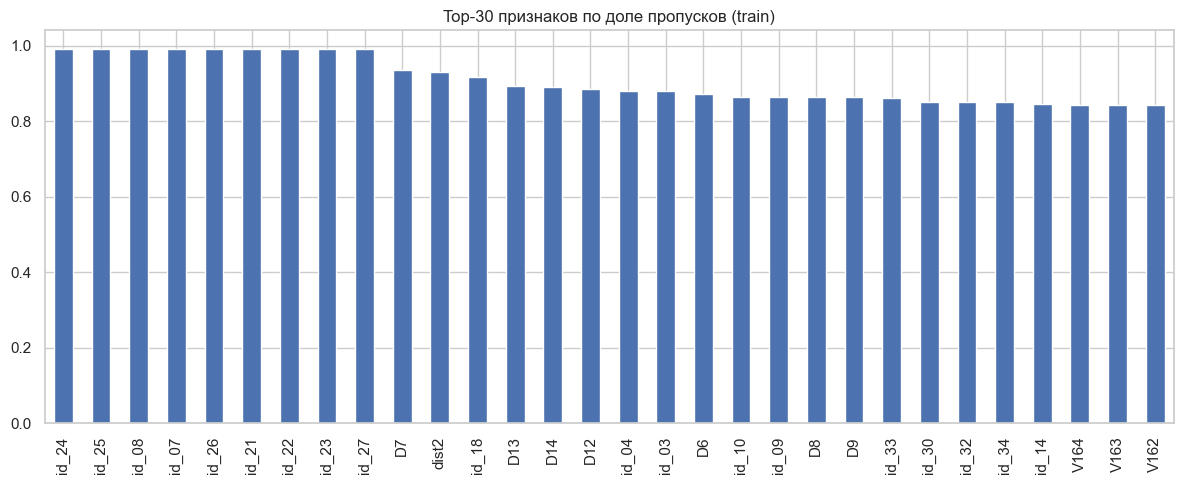

In [31]:
# Признаки с большим кол-вом пропусков

missing_rate = df_train.drop(columns=['isFraud']).isnull().mean().sort_values(ascending=False)
print("\nTop-30 признаков по доле пропусков:")
display(missing_rate.head(30))

plt.figure(figsize=(12,5))
missing_rate.head(30).plot(kind='bar')
plt.title('Top-30 признаков по доле пропусков (train)')
plt.tight_layout()
plt.show()

Есть признаки почти полностью пустые (id_24, id_25, id_08), некоторые признаки имеют более 80% пропусков (dist2, D13, D14)

Далее будем их удалаять или заполнять

## Корреляция

In [83]:
# Корреляция признаков и связь с таргетом

corr_with_target = df_train[num_cols + ['isFraud']].corr()['isFraud'].sort_values(ascending=False)
print("\nКорреляции числовых признаков с isFraud (top-20):")
display(corr_with_target.head(20))
display(corr_with_target.tail(20))


Корреляции числовых признаков с isFraud (top-20):


isFraud    1.000000
V257       0.369941
V244       0.359899
V242       0.354488
V246       0.351318
V201       0.326478
V200       0.313537
V233       0.310822
V188       0.307764
V189       0.303891
V232       0.288307
V231       0.287530
V156       0.287339
V158       0.286551
V149       0.284183
V217       0.283805
V45        0.279115
V258       0.269148
V44        0.258370
V171       0.255530
Name: isFraud, dtype: float64

V160    -0.067714
V159    -0.068270
V150    -0.069971
id_24   -0.072429
D15     -0.074128
V11     -0.078649
V10     -0.080748
D2      -0.084425
V70     -0.103839
V30     -0.106797
V69     -0.106945
V91     -0.107577
V49     -0.110035
V29     -0.110399
V90     -0.111549
V48     -0.114586
id_01   -0.125627
D7      -0.137091
D8      -0.137670
V107          NaN
Name: isFraud, dtype: float64

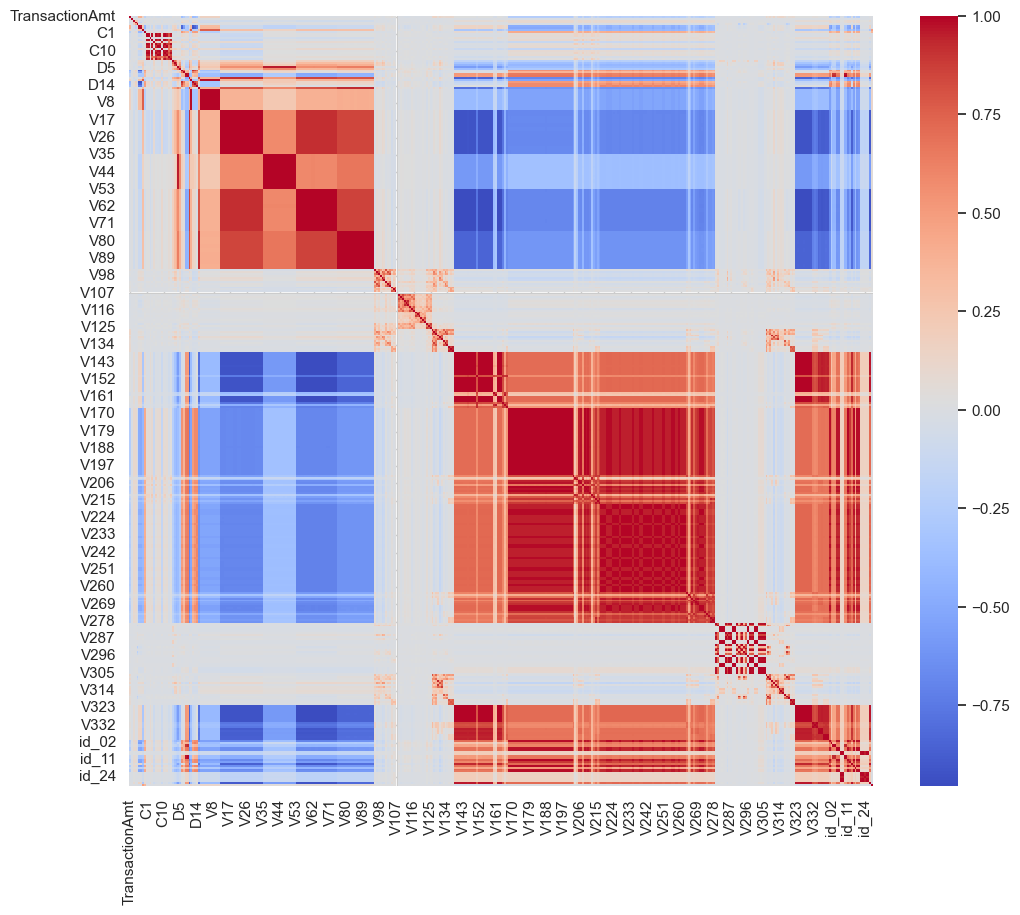

In [99]:
# Тепловая карта

plt.figure(figsize=(12,10))
sns.heatmap(df_train[num_cols].corr(), cmap="coolwarm", annot=False)
plt.show()

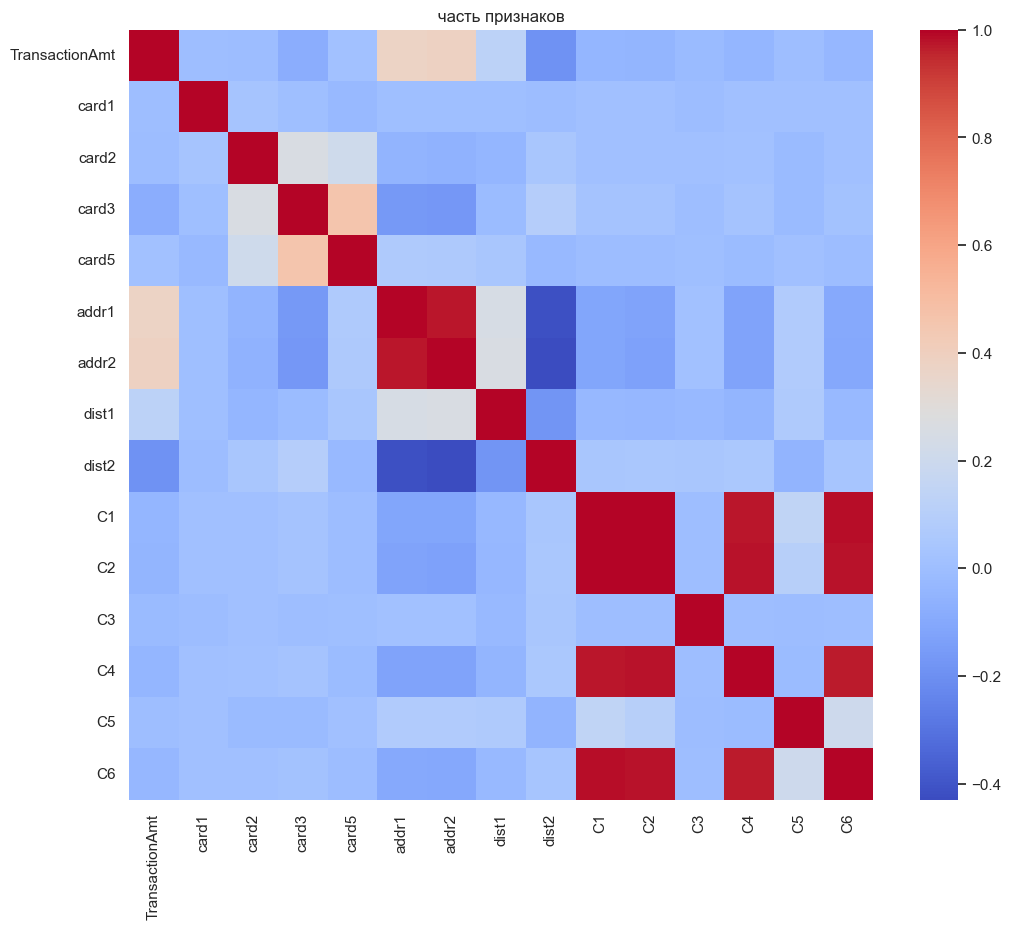

In [100]:
# Уменьшим карту

plt.figure(figsize=(12,10))
sns.heatmap(df_train[num_cols].corr().iloc[:15, :15], cmap="coolwarm", annot=False)
plt.title("часть признаков")
plt.show()

Вывод по корреляции:

Наибольшая положительная корреляция с таргетом у признаков группы V(сгенерированные признаки) Некоторые признаки имеют отрицательную корреляцию с таргетом (например, D7, D8, id_01) Наблюдаются кластеры коррелирующих признаков

## Выбросы

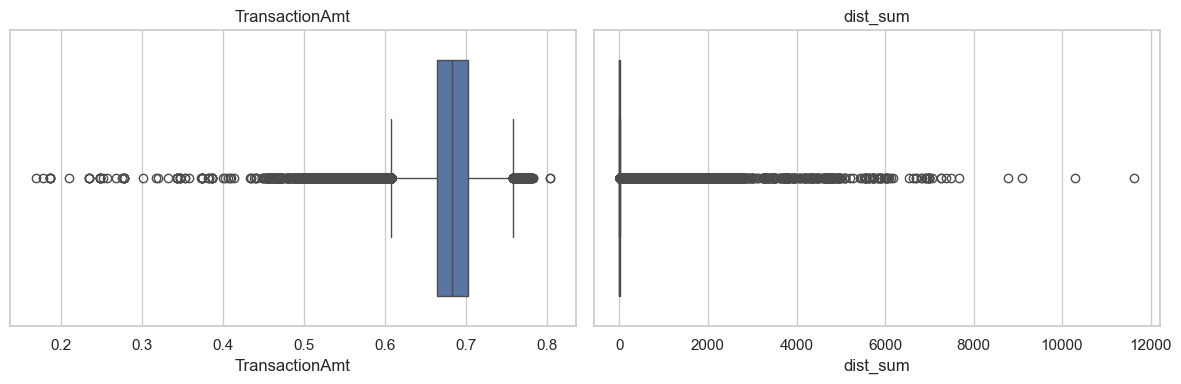

In [33]:
# Ящик с усами для примеров признаков
box_feats = ['TransactionAmt', 'dist_sum']
box_feats = [f for f in box_feats if f in df_train.columns]
if box_feats:
    plt.figure(figsize=(12,4))
    for i, col in enumerate(box_feats, 1):
        plt.subplot(1, len(box_feats), i)
        sns.boxplot(x=df_train[col], showfliers=True)
        plt.title(f'{col}')
    plt.tight_layout()
    plt.show()

В TransactionAmt и dist_sum видим выбросы, которые могут искажать модель, очистим их далее

## Очистка данных

In [27]:
# Удалим дубли целиком
before = df_train.shape[0]
df_train = df_train.drop_duplicates()
after = df_train.shape[0]
print(f"Удалено дублей: {before - after}")

Удалено дублей: 270


In [28]:
# Заполним пропуски
num_cols = df_train.drop(columns=['isFraud']).select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_train.drop(columns=['isFraud']).select_dtypes(exclude=[np.number]).columns.tolist()

df_train[num_cols] = df_train[num_cols].fillna(-999)
df_test[num_cols]  = df_test[num_cols].fillna(-999)

df_train[cat_cols] = df_train[cat_cols].fillna('-')
df_test[cat_cols]  = df_test[cat_cols].fillna('-')

In [29]:
# Явно выявляем аномалии и работаем с ними
cols_for_outliers = [c for c in ['TransactionAmt','dist_sum'] if c in df_train.columns]

new_cols = {} 
for col in cols_for_outliers:
    s = df_train[col].astype(float).replace([np.inf, -np.inf], np.nan)
    s = s.fillna(s.median())
    z = zscore(s)

    new_cols[f'{col}_z'] = z
    new_cols[f'{col}_outlier'] = (np.abs(z) > 4).astype(int)

In [30]:
df_train = pd.concat([df_train, pd.DataFrame(new_cols, index=df_train.index)], axis=1).copy()

In [31]:
outlier_flags = [c for c in df_train.columns if c.endswith('_outlier')]
mask_keep = (df_train[outlier_flags].sum(axis=1) == 0) if outlier_flags else np.ones(len(df_train), dtype=bool)

In [33]:
print(f"Удаляем явные выбросы: {(~mask_keep).sum()} строк")

df_train_clean = df_train.loc[mask_keep].reset_index(drop=True)

Удаляем явные выбросы: 6073 строк


In [ ]:
# почистим дубли в колонках
df_train_clean = df_train_clean.loc[:, ~df_train_clean.columns.duplicated()].copy()
df_test = df_test.loc[:, ~df_test.columns.duplicated()].copy()
# финальные X/y после очистки
y_train_clean = df_train_clean['isFraud'].astype(int).values
X_train_clean = df_train_clean.drop(columns=['isFraud'])
X_test_clean = df_test.copy()

print("Формы после очистки:", X_train_clean.shape, X_test_clean.shape, y_train_clean.shape)

Формы после очистки: (411216, 439) (172981, 435) (411216,)


In [82]:
# Добавим новые признаки из train в test
for col in X_train_clean.columns:
    if col not in X_test_clean.columns:
        X_test_clean[col] = -999   

X_test_clean = X_test_clean[X_train_clean.columns]

## Вывод:

- Общая информация:
Всего в тренировочном наборе 417 тыс. строк и 432 признака (399 числовых, 31 категориальный, и целевой), в тестовом 173 тыс. строк
Имеем большой объем данных (train ~ 1.3 Гб, test ~ 0.6 Гб)
Мало категориальных признаков (~ 7%) и остальные фичи - числовые
- Целевая переменная:
Сильный дисбаланс классов (более 95% - не мошеннические и менее 5% - мошеннические)
- TransactionAmt:
Распределение суммы транзакций очень скошено
После логарифмирования распределение становится ближе к нормальному, классы лучше различимы
Мошеннические транзакции чаще сосредоточены в диапазоне средних и относительно небольших сумм
- Распределение с другимим числовыми признаками:
Распределения крайне неоднородные, часто с выраженными «пиками» и дискретной структурой
card3 имеет особенно сильную концентрацию в одном значении, что может быть индикатором важности признака
Это подтверждает, что данные содержат закодированные категориальные или счётные признаки в числовом формате
- Связь признаков с таргетом:
DeviceType: устройство играет роль, причём мобильные транзакции чаще ассоциированы с мошенничеством (~10%)
Комбинации доменов e-mail: es_es и com_com имеют высокую среднюю долю мошенничества (10% и 8%)
Расстояния: мошеннические транзакции чуть более равномерно распределены и чаще имеют большие дистанции, логарифмрование улучшает различимость классов
- Пропуски:
Есть признаки почти полностью пустые (id_24, id_25, id_08), некоторые признаки имеют более 80% пропусков (dist2, D13, D14), это значит, что нам нужно их или удалять, или заполнять(что было сделано)
- Корреляция:
Наибольшая положительная корреляция с таргетом у признаков группы V(сгенерированные признаки)
Некоторые признаки имеют отрицательную корреляцию с таргетом (например, D7, D8, id_01)
Наблюдаются кластеры коррелирующих признаков
- Выбросы:
В TransactionAmt и dist_sum есть выбросы, которые могут искажать модель, явные аномалии были удалены, что должно уменьшить шум в выборке
- Очистка данных:
Было удалено 270 дублей
Числовые пропуски хаполнены -999, а категориальные "-"
Удалены строки с явными выбросами
После очистки и генерации получено: 411 тыс. строк и 439 признаков

# **2. Обучение моделей**

Обучим несколько ML-моделей для решения поставленной задачи.
Оценим их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберем число фолдов на кросс-валидации так, чтобы метрики, которые мы видим, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов построим таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставим картинкой прямо в ноутбук после ячеек с кодом для наглядности.

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

In [160]:
# Фиксируем рандом и количество потоков
RANDOM_STATE = 42
N_THREADS = os.cpu_count() or 4

In [ ]:
# Препроцессинг
# заменяем все NaN на -999 в числовых признаках
num_tf = Pipeline([("imp", SimpleImputer(strategy="constant", fill_value=-999))]) 
# заменяем все NaN на "-" и кодируем в порядковые числа (OrdinalEncoder), неизвестные категории = -1 в категориальных признаках
cat_tf = Pipeline([("imp", SimpleImputer(strategy="constant", fill_value='-')),
                   ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))])
# Собираем все преобразования в один трансформер
preprocess = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf, cat_cols)
])

In [45]:
# Подбираем число фолдов
def pick_best_kfold(Xdf, y, transformer, k_candidates=(3,5,7,10), base_model=None, random_state=42):
    # берём базовый LightGBM
    base_model = lgb.LGBMClassifier(
        n_estimators=300, 
        learning_rate=0.1, 
        num_leaves=31,
        subsample=0.8, 
        colsample_bytree=0.8,
        random_state=random_state, 
        n_jobs=-1
    )
    rows = []
    # Прогоняем разные варианты количества фолдов
    for k in k_candidates:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
        aucs = []
        # Запускаем k-fold
        for tr_idx, val_idx in skf.split(np.zeros(len(y)), y):
            # Разбиваем на train/val
            X_tr, X_va = Xdf.iloc[tr_idx], Xdf.iloc[val_idx]
            y_tr, y_va = y[tr_idx], y[val_idx]
            # Пайплайн: препроцессинг + модель
            pipe = Pipeline([("prep", transformer), ("clf", base_model)])
            pipe.fit(X_tr, y_tr)
            # Предсказания и расчёт AUC
            y_pred = pipe.predict_proba(X_va)[:,1]
            aucs.append(roc_auc_score(y_va, y_pred))
        # Сохраняем среднее и std AUC для данного k
        rows.append({"k": k, "mean_auc": float(np.mean(aucs)), "std_auc": float(np.std(aucs))})
    # Выбираем оптимальное k (минимальная дисперсия + максимальный AUC)
    diag = pd.DataFrame(rows).sort_values(["std_auc","mean_auc"], ascending=[True, False]).reset_index(drop=True)
    best_k = int(diag.loc[0,"k"])
    display(diag)
    print(f"Лучшее число фолдов = {best_k}")
    return best_k

In [52]:
# Запускаем подбор числа фолдов
N_SPLITS = pick_best_kfold(X_train_clean, y_train_clean, preprocess, k_candidates=(3,5,7,10), random_state=RANDOM_STATE)

[LightGBM] [Info] Number of positive: 9686, number of negative: 264458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35103
[LightGBM] [Info] Number of data points in the train set: 274144, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035332 -> initscore=-3.307001
[LightGBM] [Info] Start training from score -3.307001


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9685, number of negative: 264459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35244
[LightGBM] [Info] Number of data points in the train set: 274144, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307108
[LightGBM] [Info] Start training from score -3.307108


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9685, number of negative: 264459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35146
[LightGBM] [Info] Number of data points in the train set: 274144, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307108
[LightGBM] [Info] Start training from score -3.307108


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11622, number of negative: 317350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35109
[LightGBM] [Info] Number of data points in the train set: 328972, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307105
[LightGBM] [Info] Start training from score -3.307105


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11623, number of negative: 317350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35153
[LightGBM] [Info] Number of data points in the train set: 328973, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035331 -> initscore=-3.307019
[LightGBM] [Info] Start training from score -3.307019


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11623, number of negative: 317350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35247
[LightGBM] [Info] Number of data points in the train set: 328973, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035331 -> initscore=-3.307019
[LightGBM] [Info] Start training from score -3.307019


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11622, number of negative: 317351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35183
[LightGBM] [Info] Number of data points in the train set: 328973, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307109
[LightGBM] [Info] Start training from score -3.307109


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11622, number of negative: 317351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35123
[LightGBM] [Info] Number of data points in the train set: 328973, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307109
[LightGBM] [Info] Start training from score -3.307109


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 12452, number of negative: 340018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35200
[LightGBM] [Info] Number of data points in the train set: 352470, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307117
[LightGBM] [Info] Start training from score -3.307117


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 12453, number of negative: 340018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35038
[LightGBM] [Info] Number of data points in the train set: 352471, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035331 -> initscore=-3.307037
[LightGBM] [Info] Start training from score -3.307037


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 12453, number of negative: 340018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35167
[LightGBM] [Info] Number of data points in the train set: 352471, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035331 -> initscore=-3.307037
[LightGBM] [Info] Start training from score -3.307037


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 12453, number of negative: 340018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35231
[LightGBM] [Info] Number of data points in the train set: 352471, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035331 -> initscore=-3.307037
[LightGBM] [Info] Start training from score -3.307037


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 12453, number of negative: 340018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 352471, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035331 -> initscore=-3.307037
[LightGBM] [Info] Start training from score -3.307037


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 12452, number of negative: 340019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35155
[LightGBM] [Info] Number of data points in the train set: 352471, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307120
[LightGBM] [Info] Start training from score -3.307120


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 12452, number of negative: 340019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35137
[LightGBM] [Info] Number of data points in the train set: 352471, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307120
[LightGBM] [Info] Start training from score -3.307120


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13075, number of negative: 357019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35235
[LightGBM] [Info] Number of data points in the train set: 370094, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307087
[LightGBM] [Info] Start training from score -3.307087


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13075, number of negative: 357019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35082
[LightGBM] [Info] Number of data points in the train set: 370094, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307087
[LightGBM] [Info] Start training from score -3.307087


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13075, number of negative: 357019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35052
[LightGBM] [Info] Number of data points in the train set: 370094, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307087
[LightGBM] [Info] Start training from score -3.307087


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13075, number of negative: 357019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35128
[LightGBM] [Info] Number of data points in the train set: 370094, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307087
[LightGBM] [Info] Start training from score -3.307087


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13075, number of negative: 357019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35186
[LightGBM] [Info] Number of data points in the train set: 370094, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307087
[LightGBM] [Info] Start training from score -3.307087


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13075, number of negative: 357019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35109
[LightGBM] [Info] Number of data points in the train set: 370094, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307087
[LightGBM] [Info] Start training from score -3.307087


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13076, number of negative: 357019
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35207
[LightGBM] [Info] Number of data points in the train set: 370095, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035331 -> initscore=-3.307011
[LightGBM] [Info] Start training from score -3.307011


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13076, number of negative: 357019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35162
[LightGBM] [Info] Number of data points in the train set: 370095, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035331 -> initscore=-3.307011
[LightGBM] [Info] Start training from score -3.307011


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13075, number of negative: 357020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35135
[LightGBM] [Info] Number of data points in the train set: 370095, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307090
[LightGBM] [Info] Start training from score -3.307090


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 13075, number of negative: 357020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35141
[LightGBM] [Info] Number of data points in the train set: 370095, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307090
[LightGBM] [Info] Start training from score -3.307090
Диагностика k-fold:


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,k,mean_auc,std_auc
0,3,0.947505,0.002285
1,7,0.949760,0.002940
2,5,0.949014,0.003365
3,10,0.950486,0.004457


Выбранное N_SPLITS = 3


In [ ]:
# Функция для кросс-валидации с расчётом AUC
def cv_auc(pipe_or_model, Xdf, y, n_splits=None, use_pool=False, cat_idx=None):
    n_splits = N_SPLITS if n_splits is None else n_splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    # Проходим по всем фолдам
    for fold, (tr_idx, val_idx) in enumerate(tqdm(skf.split(np.zeros(len(y)), y), total=n_splits, desc="CV фолды")):
        Xtr, Xva = Xdf.iloc[tr_idx], Xdf.iloc[val_idx]
        ytr, yva = y[tr_idx], y[val_idx]
        if use_pool: # для CatBoost делаем отдельный тип пула
            train_pool = Pool(Xtr, ytr, cat_features=cat_idx)
            valid_pool = Pool(Xva, yva, cat_features=cat_idx)
            model = pipe_or_model
            model.fit(train_pool, eval_set=valid_pool, verbose=False)
            pred = model.predict_proba(valid_pool)[:,1]
        else: # для остальных моделей
            model = Pipeline([("prep", preprocess), ("clf", pipe_or_model)])
            model.fit(Xtr, ytr)
            pred = model.predict_proba(Xva)[:,1]
        # Сохраняем AUC
        scores.append(roc_auc_score(yva, pred))
    return float(np.mean(scores)), float(np.std(scores))

In [171]:
# Определяем модели и параметры для сравнения
models = {
    "CatBoost": CatBoostClassifier(
        iterations=1200, 
        depth=8, 
        learning_rate=0.05,
        l2_leaf_reg=3, 
        subsample=0.8, 
        rsm=0.8,
        loss_function="Logloss", 
        eval_metric="AUC",
        random_seed=RANDOM_STATE, 
        thread_count=N_THREADS,
        auto_class_weights="Balanced"
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=1000, 
        learning_rate=0.05, 
        num_leaves=63,
        subsample=0.8, 
        colsample_bytree=0.8,
        reg_lambda=0.5,
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS
    ),
    "XGBoost": XGBClassifier(
        n_estimators=1000, 
        learning_rate=0.05, 
        max_depth=8,
        subsample=0.8, 
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic", 
        eval_metric="auc",
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS, 
        tree_method="hist"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=800, 
        max_depth=16,
        min_samples_split=2, 
        min_samples_leaf=2,
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS
    ),
    "LogisticRegression": LogisticRegression(
        C=1.0, 
        penalty="l2",
        solver="saga", 
        max_iter=2000, 
        n_jobs=N_THREADS, 
        random_state=RANDOM_STATE
    )
}

In [ ]:
results = [] # Для сохранения результатов модели
cat_idx = [X_train_clean.columns.get_loc(c) for c in cat_cols] # индексы категориальных признаков, нужны CatBoost

In [ ]:
# Запускаем обучение, валидациюю и сохраняем сабмиты
for name, model in tqdm(models.items(), desc="Модели"):
    print(f"\n{name}")
    if name=="CatBoost": # fit и predict для кота
        mean_auc, std_auc = cv_auc(model, X_train_clean, y_train_clean, use_pool=True, cat_idx=cat_idx)
        model.fit(X_train_clean, y_train_clean, cat_features=cat_cols, verbose=False)
        preds = model.predict_proba(X_test_clean[X_train_clean.columns])[:,1]
    else: # fit и predict для всех остальных
        mean_auc, std_auc = cv_auc(model, X_train_clean, y_train_clean)
        model.fit(preprocess.fit_transform(X_train_clean), y_train_clean)
        preds = model.predict_proba(preprocess.transform(X_test_clean))[:,1]
    # сохраняем сабмит
    sub_path = f"submission_{name.lower()}.csv"
    pd.DataFrame({"TransactionID": sample_submission["TransactionID"], "isFraud": preds}).to_csv(f"outputs/{sub_path}", index=False)
    # сохраняем результаты модели
    results.append({
        "model": name,
        "cv_auc_mean": mean_auc,
        "cv_auc_std": std_auc,
        "best_params": model.get_params()
    })

Модели:   0%|          | 0/5 [00:00<?, ?it/s]


CatBoost



Модели:  20%|██        | 1/5 [47:24<3:09:39, 2844.85s/it]


LightGBM



фолды:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9650, number of negative: 263829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35675
[LightGBM] [Info] Number of data points in the train set: 273479, number of used features: 437
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035286 -> initscore=-3.308343
[LightGBM] [Info] Start training from score -3.308343


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

фолды:  33%|███▎      | 1/3 [00:36<01:12, 36.32s/it]

[LightGBM] [Info] Number of positive: 9650, number of negative: 263829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35746
[LightGBM] [Info] Number of data points in the train set: 273479, number of used features: 437
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035286 -> initscore=-3.308343
[LightGBM] [Info] Start training from score -3.308343


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

фолды:  67%|██████▋   | 2/3 [01:12<00:36, 36.21s/it]

[LightGBM] [Info] Number of positive: 9650, number of negative: 263830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35605
[LightGBM] [Info] Number of data points in the train set: 273480, number of used features: 437
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035286 -> initscore=-3.308347
[LightGBM] [Info] Start training from score -3.308347


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

CV фолды: 100%|██████████| 3/3 [01:48<00:00, 36.02s/it]


[LightGBM] [Info] Number of positive: 14475, number of negative: 395744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35555
[LightGBM] [Info] Number of data points in the train set: 410219, number of used features: 437
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035286 -> initscore=-3.308345
[LightGBM] [Info] Start training from score -3.308345


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Модели:  40%|████      | 2/5 [49:59<1:03:06, 1262.24s/it]


XGBoost



Модели:  60%|██████    | 3/5 [53:34<26:08, 784.26s/it]   


RandomForest



Модели:  80%|████████  | 4/5 [1:03:33<11:51, 711.01s/it]


LogisticRegression



D:\Soft\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

D:\Soft\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

D:\Soft\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

CV фолды: 100%|██████████| 3/3 [1:06:39<00:00, 1333.17s/it]
D:\Soft\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Модели: 100%|██████████| 5/5 [2:43:10<00:00, 1958.19s/it]


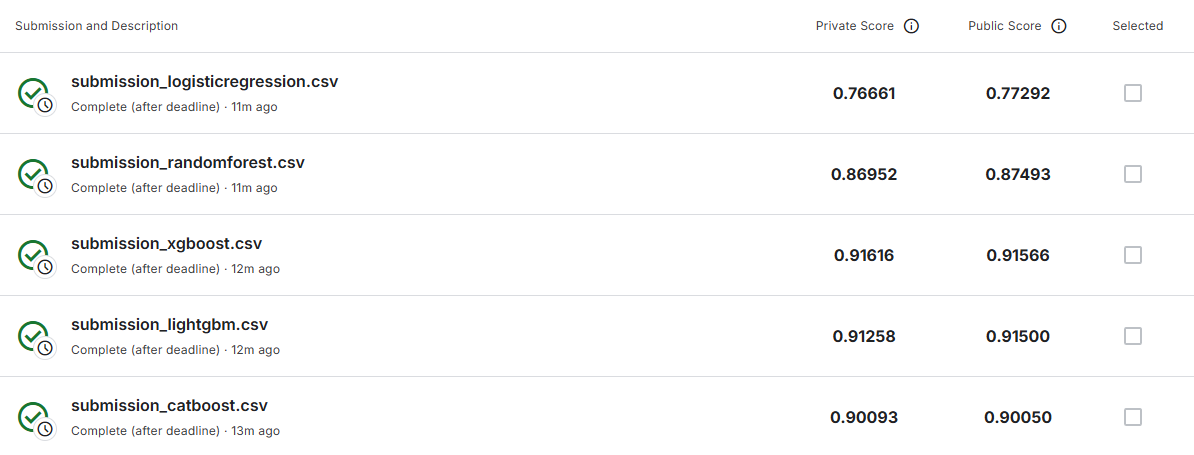

In [210]:
res_final = pd.DataFrame(results).sort_values("cv_auc_mean", ascending=False).reset_index(drop=True) # сортируем по локальному скору
# Добавляем результаты с кагла
kaggle_scores = { 
    "CatBoost": 0.90050,
    "LightGBM": 0.91500,
    "XGBoost": 0.91566,
    "RandomForest": 0.87493,
    "LogisticRegression": 0.77292
}

res_final["kaggle_score"] = res_final["model"].map(kaggle_scores)

display(res_final)

,model,cv_auc_mean,best_params,kaggle_score
0,XGBoost,0.964122,"{'objective': 'binary:logistic', 'base_score':...",0.91566
1,LightGBM,0.963700,"{'boosting_type': 'gbdt', 'class_weight': None...",0.91500
2,CatBoost,0.957387,"{'iterations': 1200, 'learning_rate': 0.05, 'd...",0.90050
3,RandomForest,0.896520,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.87493
4,LogisticRegression,0.763398,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.77292


## Вывод:

- Виден явный разрыв между более простыми моделями и бустингами с подбором кол-ва фолдов
- Лучший результат показал XGB, но LGBM практически равен ему

# **3. Поиск аномалий**

Попробуем подойти к задаче как к поиску аномалий.

1) Поищием аномалии (фрод) различными методами и сделаем прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество нашего решения на leaderboard

2) Попробуйем встроить поиск аномалий и их удаление в ML-пайплайн.

In [84]:
from pathlib import Path
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.decomposition import PCA

In [ ]:
sns.set(style="whitegrid")
OUT_DIR = "anomaly_outputs" # Сделаем отдельную директорию для сабмитов аномалий
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

In [228]:
# Используем те же трансформеры, что и для обучения моделей
preprocess_for_anom = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ],
    remainder="drop"
)
# Преобразуем train и test
X_anom = preprocess_for_anom.fit_transform(X_train_clean, y_train_clean)
X_test_anom = preprocess_for_anom.transform(X_test_clean)
# Стандартизация признаков
scaler = StandardScaler()
X_anom_std = scaler.fit_transform(X_anom)
X_test_anom_std = scaler.transform(X_test_anom)

In [89]:
# Нормализуем массив в вероятность [0,1] (ранговая нормализация)
def to_rank01(arr):
    arr = np.asarray(arr, dtype=float)
    ranks = pd.Series(arr).rank(method="average").values
    return (ranks - 1) / (len(ranks) - 1 + 1e-12)

In [90]:
# Тут сделано сохранение сабмита от алгоритмов, чтобы не писать снова ручками
def save_submission(scores_test, name):
    probs = to_rank01(scores_test) # переводим сырые скоры в вероятности
    # сохраняем
    sub = pd.DataFrame({"TransactionID": sample_submission["TransactionID"], "isFraud": probs})
    path = os.path.join(OUT_DIR, f"submission_anom_{name}.csv")
    sub.to_csv(path, index=False)
    return path

In [91]:
# Ристуем ящик с усами и распределение с плотностью
def plot_scores_by_class(train_scores, y, title):
    dfp = pd.DataFrame({"score": train_scores, "isFraud": y})
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.boxplot(data=dfp, x="isFraud", y="score", showfliers=False, ax=axes[0])
    axes[0].set_title(f"{title} — Boxplot")
    sns.violinplot(data=dfp, x="isFraud", y="score", inner="quart", cut=0, density_norm="width", ax=axes[1])
    axes[1].set_title(f"{title} — Violin")
    plt.tight_layout()
    plt.show()

In [92]:
# Для визуализации PCA
def scatter_anomaly_scores(X_std, scores, y, title, s=6, alpha=0.6):
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X_std)
    # Делаем min-max нормализацию для корректного PCA (насколько я знаю, с ранговой графики хуже)
    sc = (scores - np.min(scores)) / (np.max(scores) - np.min(scores) + 1e-12)

    plt.figure(figsize=(7.5, 6))
    mask0 = (y == 0)
    mask1 = (y == 1)
    # обычные транзакции
    plt.scatter(X2[mask0, 0], X2[mask0, 1], c=sc[mask0], s=s, alpha=alpha, cmap="viridis", label="isFraud=0")
    # мошеннические транзакции
    plt.scatter(X2[mask1, 0], X2[mask1, 1], c=sc[mask1], s=s*1.4, alpha=min(1.0, alpha+0.15), cmap="viridis", edgecolor='k', linewidths=0.2, label="isFraud=1")

    cb = plt.colorbar()
    cb.set_label("score")

    var = pca.explained_variance_ratio_.sum()
    plt.title(f"{title} — PCA scatter  |  var={var:.2f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [94]:
# Для рассчета IQR
def iqr_flags(X):
    # Считаем Q1 и Q3
    q1 = np.nanpercentile(X, 25, axis=0)
    q3 = np.nanpercentile(X, 75, axis=0)
    # Считаем границы
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    # Если объект за границами = выброс
    flags = (X < lo) | (X > hi)
    return flags.astype(int)

In [95]:
# Ищем расстояния до ближайших соседей
def knn_anomaly_scores(X_train_std, X_test_std, k=10):
    nn = NearestNeighbors(n_neighbors=k+1, algorithm="auto", n_jobs=-1)
    nn.fit(X_train_std)
    # для train берём соседей [1:], исключаем самого себя
    d_tr, _ = nn.kneighbors(X_train_std, n_neighbors=k+1, return_distance=True)
    d_te, _ = nn.kneighbors(X_test_std,  n_neighbors=k,    return_distance=True) 
    score_train = d_tr[:, 1:].mean(axis=1)
    score_test  = d_te.mean(axis=1)
    return score_train, score_test

In [106]:
results_anom = []
methods = ["IQR", "EllipticEnvelope", "IsolationForest", "KNN"]

  0%|          | 0/4 [00:00<?, ?it/s]

IQR
Доля объектов с >=1 выбросом по IQR: 0.9022


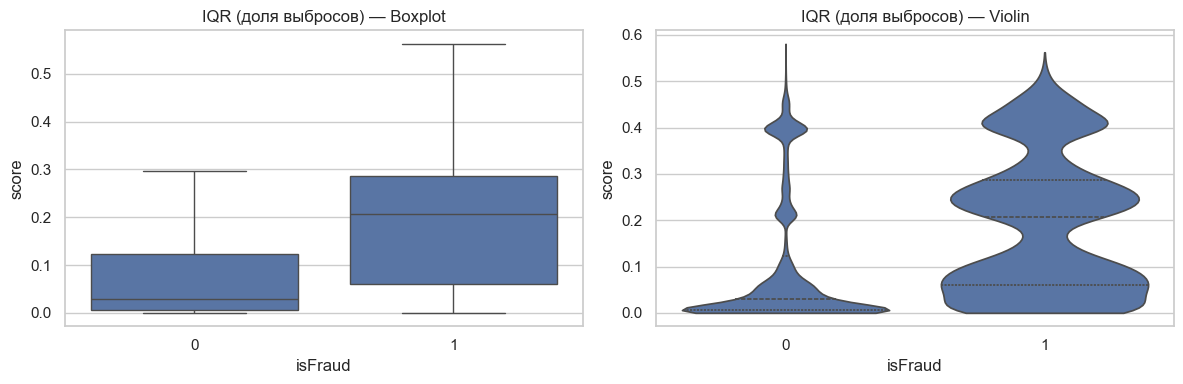

 25%|██▌       | 1/4 [00:11<00:33, 11.33s/it]

EllipticEnvelope


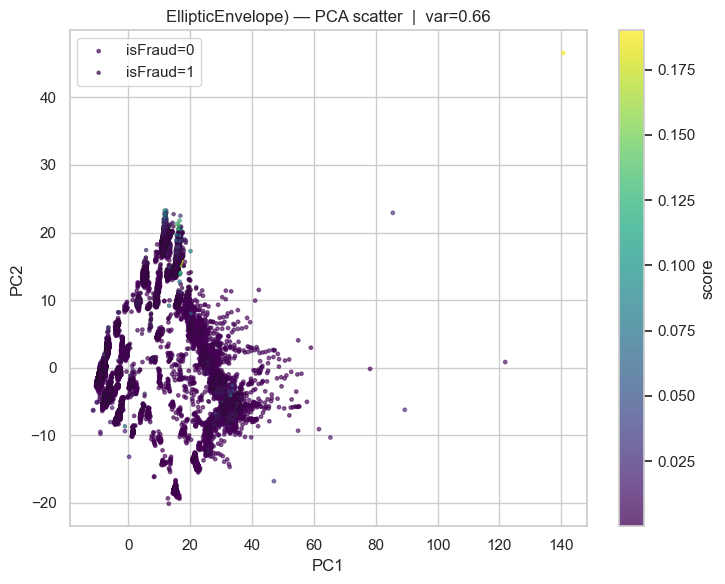

 50%|█████     | 2/4 [02:03<02:21, 70.94s/it]

IsolationForest


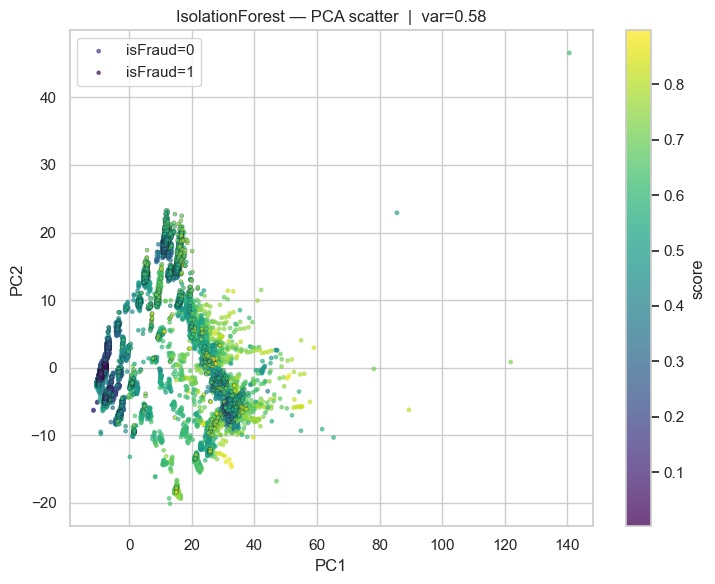

 75%|███████▌  | 3/4 [02:35<00:52, 52.82s/it]

KNN


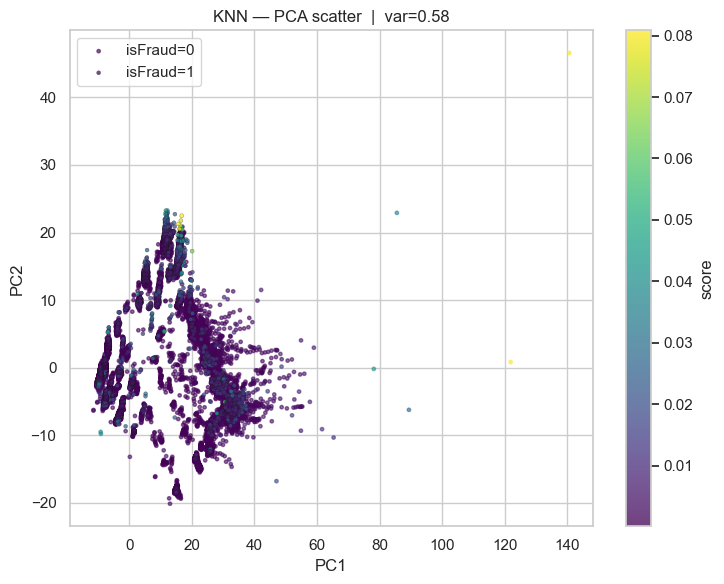

100%|██████████| 4/4 [15:23<00:00, 230.76s/it]


In [108]:
# Прогоняем методы
for method in tqdm(methods):
    print(f"{method}")

    if method == "IQR":
        iqr_flags_train = iqr_flags(X_anom)
        iqr_flags_test  = iqr_flags(X_test_anom)
        # скор = доля признаков, вышедших за пределы
        iqr_score_train = iqr_flags_train.mean(axis=1)
        iqr_score_test  = iqr_flags_test.mean(axis=1)
        # сколько объектов имеют >=1 выброс
        share_outliers = (iqr_flags_train.sum(axis=1) > 0).mean()
        print(f"Доля объектов с >=1 выбросом по IQR: {share_outliers:.4f}")
        # AUC
        auc_iqr = roc_auc_score(y_train_clean, iqr_score_train)
        # График
        plot_scores_by_class(iqr_score_train, y_train_clean, "IQR (доля выбросов)")
        # Сабмит
        path_iqr = save_submission(iqr_score_test, "IQR")

        results_anom.append({"method":"IQR", "train_auc": auc_iqr, "kaggle_score": np.nan})

    elif method == "EllipticEnvelope":
        n_comp = 20 # Уменьшаем кол-во компанент до 20
        pca = PCA(n_components=n_comp, random_state=42)

        X_pca_train = pca.fit_transform(X_anom_std)
        X_pca_test  = pca.transform(X_test_anom_std)
        # Эллиптическая оболочка
        ee = EllipticEnvelope(random_state=42, contamination=0.1)
        ee.fit(X_pca_train)
        # скор = отрицательная decision_function
        ee_train = -ee.decision_function(X_pca_train)
        ee_test  = -ee.decision_function(X_pca_test)

        auc_ee = roc_auc_score(y_train_clean, ee_train)
        path_ee = save_submission(ee_test, "EllipticEnvelope")
        scatter_anomaly_scores(X_pca_train, ee_train, y_train_clean,title="EllipticEnvelope)")
        results_anom.append({"method":"EllipticEnvelope", "train_auc": auc_ee, "kaggle_score": np.nan})

    elif method == "IsolationForest":
        # берем легкие параметры для леса
        iso = IsolationForest(
            n_estimators=300, 
            contamination=0.1,
            random_state=42, 
            n_jobs=-1
        )
        # Прогоняем
        iso.fit(X_anom)
        # Скор берем как в ЕЕ
        iso_train = -iso.decision_function(X_anom)
        iso_test  = -iso.decision_function(X_test_anom)

        auc_iso = roc_auc_score(y_train_clean, iso_train)
        path_iso = save_submission(iso_test, "IsolationForest")
        scatter_anomaly_scores(X_anom_std, iso_train, y_train_clean, title="IsolationForest")
        results_anom.append({"method":"IsolationForest", "train_auc": auc_iso, "kaggle_score": np.nan})

    elif method == "KNN":
        knn_train, knn_test = knn_anomaly_scores(X_anom_std, X_test_anom_std, k=10)

        auc_knn = roc_auc_score(y_train_clean, knn_train)
        path_knn = save_submission(knn_test, "KNN")
        scatter_anomaly_scores(X_anom_std, knn_train, y_train_clean, title="KNN")
        results_anom.append({"method":"KNN", "train_auc": auc_knn, "kaggle_score": np.nan})

Выводы:

- IQR:
Видим, что у мошеннических транзакций доля выбросов заметно выше, чем у обычных => это говорит о том, что мошеннические транзакции чаще выбиваются за границы нормального распределения
- EllipticEnvelope:
PCA показал, что модель находит аномалии, но распределение аномальных значений довольно "компактное".
Видно, что метод хуже отделяет мошенничество: большинство точек, независимо от класса, лежат в одной зоне
- IsolationForest:
На графике заметна хорошая градация значений score: мошеннические транзакции имеют значительно более высокие аномальные оценки
Метод эффективно изолирует редкие/аномальные объекты, поэтому здесь его разделяющая способность выше, чем у IQR и EllipticEnvelope
PCA показывает, что фроды подсвечиваются более четко, особенно на краях
- KNN:
Мошеннические и обычные транзакции перемешаны, а значения скора низкие и почти одинаковые. Скорее всего это связано с высокой размерностью данных: метрика расстояний "размывается" и KNN теряет эффективность

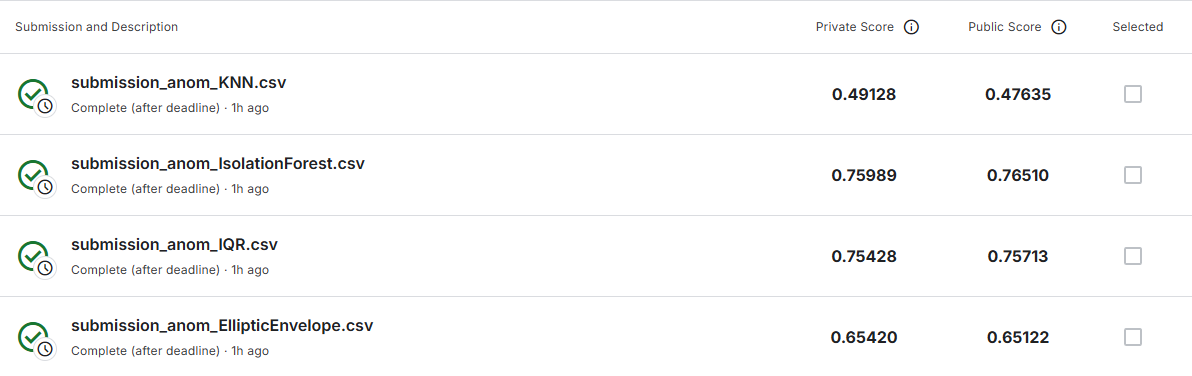

In [89]:
anom_df = pd.DataFrame(results_anom).sort_values("train_auc", ascending=False).reset_index(drop=True)

kaggle_scores = {
    "IQR": 0.75713,
    "EllipticEnvelope": 0.65122,
    "IsolationForest": 0.76510,
    "KNN": 0.47635
}

anom_df["kaggle_score"] = anom_df["method"].map(kaggle_scores).combine_first(anom_df["kaggle_score"])
    
display(anom_df)

,method,train_auc,kaggle_score
0,IsolationForest,0.746804,0.76510
1,IQR,0.713362,0.75713
2,EllipticEnvelope,0.712773,0.65122
3,KNN,0.702064,0.47635


In [109]:
# Добавляем аномалии как признаки
anom_features_train = pd.DataFrame(index=np.arange(len(X_train_clean)))
anom_features_test  = pd.DataFrame(index=np.arange(len(X_test_clean)))

In [110]:
# IQR
iqr_flags_train = iqr_flags(X_anom)
iqr_flags_test  = iqr_flags(X_test_anom)
anom_features_train["IQR_score"] = iqr_flags_train.mean(axis=1)
anom_features_test["IQR_score"]  = iqr_flags_test.mean(axis=1)

In [111]:
# EllipticEnvelope
pca = PCA(n_components=20, random_state=42)
X_pca_train = pca.fit_transform(X_anom_std)
X_pca_test  = pca.transform(X_test_anom_std)
ee = EllipticEnvelope(random_state=42, contamination=0.1)
ee.fit(X_pca_train)
anom_features_train["EE_score"] = -ee.decision_function(X_pca_train)
anom_features_test["EE_score"]  = -ee.decision_function(X_pca_test)

In [112]:
# IsolationForest
iso = IsolationForest(
    n_estimators=300, contamination=0.1,
    random_state=42, n_jobs=-1
)
iso.fit(X_anom)
anom_features_train["IF_score"] = -iso.decision_function(X_anom)
anom_features_test["IF_score"]  = -iso.decision_function(X_test_anom)

In [113]:
# KNN
knn_train, knn_test = knn_anomaly_scores(X_anom_std, X_test_anom_std, k=10)
anom_features_train["KNN_score"] = knn_train
anom_features_test["KNN_score"]  = knn_test

In [114]:
print("Аномальные признаки рассчитаны:", anom_features_train.shape)

Аномальные признаки рассчитаны: (411216, 4)


In [114]:
# Дополняем датасеты новыми признаками
X_train_aug = pd.concat([X_train_clean.reset_index(drop=True), anom_features_train.reset_index(drop=True)], axis=1)
X_test_aug  = pd.concat([X_test_clean.reset_index(drop=True), anom_features_test.reset_index(drop=True)], axis=1)

In [117]:
# Берем более быстрые в обучении модели
models_anom = {
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=1000, 
        learning_rate=0.05, 
        num_leaves=63,
        subsample=0.8, 
        colsample_bytree=0.8,
        reg_lambda=0.5,
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS
    ),
    "XGBoost": XGBClassifier(
        n_estimators=1000, 
        learning_rate=0.05, 
        max_depth=8,
        subsample=0.8, 
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic", 
        eval_metric="auc",
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS, 
        tree_method="hist"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=800, 
        max_depth=16,
        min_samples_split=2, 
        min_samples_leaf=2,
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS
    )
}

In [118]:
results_anom_mod = []

In [ ]:
# Прогоняем модели
for name, model in tqdm(models_anom.items(), desc="Модели c аномалиями"):
    print(f"\n{name}")
    mean_auc, std_auc = cv_auc(model, X_train_aug, y_train_clean)
    
    model.fit(preprocess.fit_transform(X_train_aug), y_train_clean)
    preds = model.predict_proba(preprocess.transform(X_test_aug))[:,1]
    
    sub_path = f"submission_with_anom_{name.lower()}.csv"
    pd.DataFrame({"TransactionID": sample_submission["TransactionID"], "isFraud": preds}).to_csv(f"anomaly_outputs/{sub_path}", index=False)
    
    results_anom_mod.append({
        "model": name,
        "cv_auc_mean": mean_auc,
        "cv_auc_std": std_auc,
        "kaggle_score": np.nan
    })

Модели c аномалиями:   0%|          | 0/3 [00:00<?, ?it/s]


LightGBM



фолды:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9686, number of negative: 264458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35103
[LightGBM] [Info] Number of data points in the train set: 274144, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035332 -> initscore=-3.307001
[LightGBM] [Info] Start training from score -3.307001


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

фолды:  33%|███▎      | 1/3 [00:34<01:08, 34.26s/it]

[LightGBM] [Info] Number of positive: 9685, number of negative: 264459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35244
[LightGBM] [Info] Number of data points in the train set: 274144, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307108
[LightGBM] [Info] Start training from score -3.307108


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

фолды:  67%|██████▋   | 2/3 [01:09<00:34, 34.58s/it]

[LightGBM] [Info] Number of positive: 9685, number of negative: 264459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35146
[LightGBM] [Info] Number of data points in the train set: 274144, number of used features: 435
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035328 -> initscore=-3.307108
[LightGBM] [Info] Start training from score -3.307108


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(

CV фолды: 100%|██████████| 3/3 [01:46<00:00, 35.54s/it]


[LightGBM] [Info] Number of positive: 14528, number of negative: 396688
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35189
[LightGBM] [Info] Number of data points in the train set: 411216, number of used features: 436
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035329 -> initscore=-3.307072
[LightGBM] [Info] Start training from score -3.307072


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Модели c аномалиями:  33%|███▎      | 1/3 [02:29<04:58, 149.07s/it]


XGBoost



Модели c аномалиями:  67%|██████▋   | 2/3 [05:59<03:05, 185.42s/it]


RandomForest



Модели c аномалиями: 100%|██████████| 3/3 [15:46<00:00, 315.36s/it]


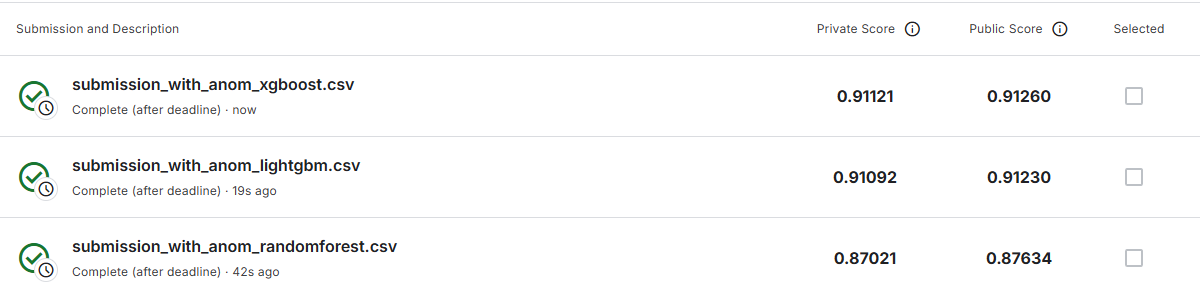

In [140]:
res_anom = pd.DataFrame(results_anom_mod).sort_values("cv_auc_mean", ascending=False).reset_index(drop=True)

kaggle_scores = {
    "LightGBM": 0.91230,
    "XGBoost": 0.91260,
    "RandomForest": 0.87634,
}

res_anom["kaggle_score"] = res_anom["model"].map(kaggle_scores)

display(res_anom)

,model,cv_auc_mean,cv_auc_std,kaggle_score
0,XGBoost,0.964351,0.001330,0.91260
1,LightGBM,0.964234,0.001864,0.91230
2,RandomForest,0.896726,0.000504,0.87634


## Выводы:

На кросс-валидации показатели бустингов практически не улучшились, а вот на kaggle качество снизилось, скорее всего новые признаки немного переобучили модели

Деревья показали небольшой прирост как на кросс-валидации, так и на kaggle

# **4. Кластеризация**

Сделаем кластеризацию различными способами. Результаты кластеризации используем для улучшения ML-решений:

1) Номера кластеров закодируем (OHE или target-encoding) и добавим как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

In [131]:
from sklearn.cluster import DBSCAN

In [116]:
# DBSCAN
dbscan = DBSCAN(eps=3, min_samples=20, n_jobs=-1) # разделим на 3 кластера, с мин. числом точек = 20
# Обучаем DBSCAN на стандартизированных данных (только числовые признаки)
labels_db = dbscan.fit_predict(X_anom_std)

# Сохраняем номера кластеров как новый категориальный признак
X_train_aug["dbscan_cluster"] = labels_db
# Для тестового набора (где нет кластеризации) присваиваем фиктивное значение -1
X_test_aug["dbscan_cluster"] = -1

# Создаем бинарный признак шума
X_train_aug["dbscan_is_noise"] = (labels_db == -1).astype(int)
# Для тестового набора шум обозначаем как 1 (так как мы не знаем настоящие кластеры)
X_test_aug["dbscan_is_noise"]  = 1

In [117]:
# target encoding 
# Для каждой метки кластера вычисляем среднее значение "dbscan_is_noise"
means = X_train_aug.groupby("dbscan_cluster")["dbscan_is_noise"].mean()
# Заменяем метку кластера на её среднее значение по "шуму" (если метки нет — заполняем 0)
X_train_aug["dbscan_cluster_te"] = X_train_aug["dbscan_cluster"].map(means).fillna(0)
X_test_aug["dbscan_cluster_te"]  = X_test_aug["dbscan_cluster"].map(means).fillna(0)

In [118]:
# Сохраняем версии выборок для обучения моделей
X_train_cluster = X_train_aug.copy()
X_test_cluster  = X_test_aug.copy()

In [ ]:
# Берем модели аналогично 3 пункту
models_cluster = {
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=1000, 
        learning_rate=0.05, 
        num_leaves=63,
        subsample=0.8, 
        colsample_bytree=0.8,
        reg_lambda=0.5,
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS
    ),
    "XGBoost": XGBClassifier(
        n_estimators=1000, 
        learning_rate=0.05, 
        max_depth=8,
        subsample=0.8, 
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic", 
        eval_metric="auc",
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS, 
        tree_method="hist"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=800, 
        max_depth=16,
        min_samples_split=2, 
        min_samples_leaf=2,
        random_state=RANDOM_STATE, 
        n_jobs=N_THREADS
    )
}

In [120]:
results_cluster = []

In [ ]:
# Прогоняем аналогично пункту 2 и 3
for name, model in tqdm(models_cluster.items(), desc="Модели с кластерами"):
    print(f"\n{name}")
    mean_auc, std_auc = cv_auc(model, X_train_cluster, y_train_clean)

    model.fit(preprocess.fit_transform(X_train_cluster), y_train_clean)
    preds = model.predict_proba(preprocess.transform(X_test_cluster))[:,1]

    sub_path = f"submission_clusters_{name.lower()}.csv"
    pd.DataFrame({"TransactionID": sample_submission["TransactionID"], "isFraud": preds}).to_csv(f"clusters_outputs/{sub_path}", index=False)

    results_cluster.append({
        "model": name,
        "cv_auc_mean": mean_auc,
        "cv_auc_std": std_auc,
        "kaggle_score": np.nan
    })

Модели с кластерами:   0%|          | 0/3 [00:00<?, ?it/s]


LightGBM



Модели с кластерами:   0%|          | 0/3 [00:00<?, ?it/s]


IndexError: positional indexers are out-of-bounds

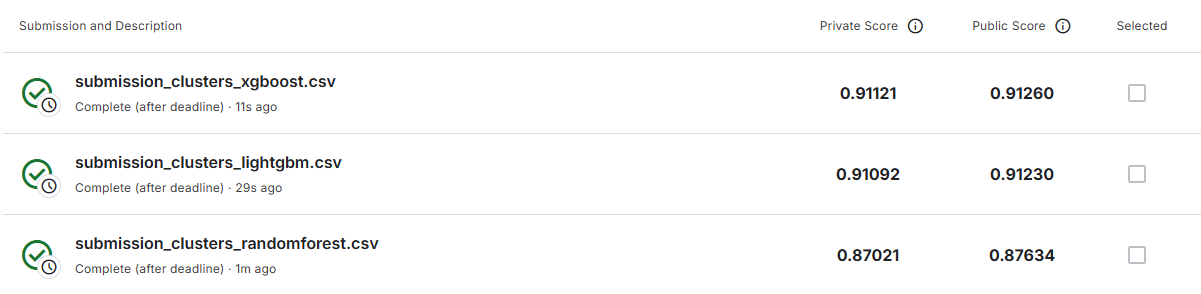

In [141]:
res_cluster_df = pd.DataFrame(results_cluster).sort_values("cv_auc_mean", ascending=False).reset_index(drop=True)

kaggle_scores = {
    "LightGBM": 0.91230,
    "XGBoost": 0.91260,
    "RandomForest": 0.87634,
}

res_cluster_df["kaggle_score"] = res_cluster_df["model"].map(kaggle_scores)

display(res_cluster_df)

,model,cv_auc_mean,cv_auc_std,kaggle_score
0,XGBoost,0.964351,0.001330,0.91260
1,LightGBM,0.964234,0.001864,0.91230
2,RandomForest,0.896726,0.000504,0.87634


## Вывод:

Скоры не изменились, возможно, что модели уже видят кластерные закономерности 

(или я где-то накосячил :) )

# **5. AutoML**

Попробуем применить какой-нибудь AutoML фреймворк для решения поставленной задачи.

In [146]:
from flaml import AutoML

In [154]:
X_tr_num = preprocess.fit_transform(X_train_clean)
X_te_num = preprocess.transform(X_test_clean)

In [164]:
automl = AutoML()

automl_settings = {
    "time_budget": 3600,              
    "metric": "roc_auc",
    "task": "classification",
    "estimator_list": ["lgbm", "xgboost", "rf", "lrl2", "lrl1", "catboost"],
    "n_jobs": N_THREADS,
    "seed": RANDOM_STATE,
}

In [166]:
automl.fit(X_train=X_tr_num, y_train=y_train_clean, **automl_settings)

[flaml.automl.logger: 10-02 21:16:05] {1752} INFO - task = classification
[flaml.automl.logger: 10-02 21:16:05] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 10-02 21:16:07] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 10-02 21:16:07] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'lrl2', 'lrl1', 'catboost']
[flaml.automl.logger: 10-02 21:16:07] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-02 21:16:07] {2417} INFO - Estimated sufficient time budget=73279s. Estimated necessary time budget=1499s.
[flaml.automl.logger: 10-02 21:16:07] {2466} INFO -  at 1.7s,	estimator lgbm's best error=0.2060,	best estimator lgbm's best error=0.2060
[flaml.automl.logger: 10-02 21:16:07] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-02 21:16:07] {2466} INFO -  at 1.8s,	estimator lgbm's best error=0.2034,	best estimator lgbm's best error=0.2034


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:07] {2282} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 10-02 21:16:07] {2466} INFO -  at 2.0s,	estimator lgbm's best error=0.1729,	best estimator lgbm's best error=0.1729
[flaml.automl.logger: 10-02 21:16:07] {2282} INFO - iteration 3, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:07] {2466} INFO -  at 2.2s,	estimator lgbm's best error=0.1387,	best estimator lgbm's best error=0.1387
[flaml.automl.logger: 10-02 21:16:07] {2282} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 10-02 21:16:08] {2466} INFO -  at 2.4s,	estimator lgbm's best error=0.1292,	best estimator lgbm's best error=0.1292
[flaml.automl.logger: 10-02 21:16:08] {2282} INFO - iteration 5, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:08] {2466} INFO -  at 2.6s,	estimator lgbm's best error=0.1292,	best estimator lgbm's best error=0.1292
[flaml.automl.logger: 10-02 21:16:08] {2282} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 10-02 21:16:08] {2466} INFO -  at 3.0s,	estimator lgbm's best error=0.1198,	best estimator lgbm's best error=0.1198
[flaml.automl.logger: 10-02 21:16:08] {2282} INFO - iteration 7, current learner xgboost
[flaml.automl.logger: 10-02 21:16:08] {2466} INFO -  at 3.1s,	estimator xgboost's best error=0.2060,	best estimator lgbm's best error=0.1198
[flaml.automl.logger: 10-02 21:16:08] {2282} INFO - iteration 8, current learner xgboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:08] {2466} INFO -  at 3.2s,	estimator xgboost's best error=0.2060,	best estimator lgbm's best error=0.1198
[flaml.automl.logger: 10-02 21:16:08] {2282} INFO - iteration 9, current learner xgboost
[flaml.automl.logger: 10-02 21:16:08] {2466} INFO -  at 3.3s,	estimator xgboost's best error=0.1613,	best estimator lgbm's best error=0.1198
[flaml.automl.logger: 10-02 21:16:08] {2282} INFO - iteration 10, current learner rf
[flaml.automl.logger: 10-02 21:16:09] {2466} INFO -  at 3.5s,	estimator rf's best error=0.2710,	best estimator lgbm's best error=0.1198
[flaml.automl.logger: 10-02 21:16:09] {2282} INFO - iteration 11, current learner rf
[flaml.automl.logger: 10-02 21:16:09] {2466} INFO -  at 3.6s,	estimator rf's best error=0.2141,	best estimator lgbm's best error=0.1198
[flaml.automl.logger: 10-02 21:16:09] {2282} INFO - iteration 12, current learner xgboost
[flaml.automl.logger: 10-02 21:16:09] {2466} INFO -  at 3.8s,	estimator xgboost's best error=0.16

D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:10] {2282} INFO - iteration 17, current learner lgbm
[flaml.automl.logger: 10-02 21:16:10] {2466} INFO -  at 4.8s,	estimator lgbm's best error=0.1165,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 10-02 21:16:10] {2282} INFO - iteration 18, current learner xgboost
[flaml.automl.logger: 10-02 21:16:10] {2466} INFO -  at 4.9s,	estimator xgboost's best error=0.1613,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 10-02 21:16:10] {2282} INFO - iteration 19, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:10] {2466} INFO -  at 5.3s,	estimator lgbm's best error=0.1165,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 10-02 21:16:10] {2282} INFO - iteration 20, current learner xgboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:11] {2466} INFO -  at 5.6s,	estimator xgboost's best error=0.1370,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 10-02 21:16:11] {2282} INFO - iteration 21, current learner lgbm
[flaml.automl.logger: 10-02 21:16:12] {2466} INFO -  at 6.6s,	estimator lgbm's best error=0.1165,	best estimator lgbm's best error=0.1165
[flaml.automl.logger: 10-02 21:16:12] {2282} INFO - iteration 22, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:12] {2466} INFO -  at 7.4s,	estimator lgbm's best error=0.0990,	best estimator lgbm's best error=0.0990
[flaml.automl.logger: 10-02 21:16:12] {2282} INFO - iteration 23, current learner rf
[flaml.automl.logger: 10-02 21:16:13] {2466} INFO -  at 7.5s,	estimator rf's best error=0.1617,	best estimator lgbm's best error=0.0990
[flaml.automl.logger: 10-02 21:16:13] {2282} INFO - iteration 24, current learner rf


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:13] {2466} INFO -  at 7.7s,	estimator rf's best error=0.1617,	best estimator lgbm's best error=0.0990
[flaml.automl.logger: 10-02 21:16:13] {2282} INFO - iteration 25, current learner lgbm
[flaml.automl.logger: 10-02 21:16:13] {2466} INFO -  at 8.3s,	estimator lgbm's best error=0.0990,	best estimator lgbm's best error=0.0990
[flaml.automl.logger: 10-02 21:16:13] {2282} INFO - iteration 26, current learner xgboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:14] {2466} INFO -  at 8.7s,	estimator xgboost's best error=0.1361,	best estimator lgbm's best error=0.0990
[flaml.automl.logger: 10-02 21:16:14] {2282} INFO - iteration 27, current learner rf
[flaml.automl.logger: 10-02 21:16:14] {2466} INFO -  at 8.8s,	estimator rf's best error=0.1617,	best estimator lgbm's best error=0.0990
[flaml.automl.logger: 10-02 21:16:14] {2282} INFO - iteration 28, current learner rf
[flaml.automl.logger: 10-02 21:16:14] {2466} INFO -  at 9.0s,	estimator rf's best error=0.1617,	best estimator lgbm's best error=0.0990
[flaml.automl.logger: 10-02 21:16:14] {2282} INFO - iteration 29, current learner lgbm
[flaml.automl.logger: 10-02 21:16:15] {2466} INFO -  at 9.9s,	estimator lgbm's best error=0.0990,	best estimator lgbm's best error=0.0990
[flaml.automl.logger: 10-02 21:16:15] {2282} INFO - iteration 30, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:19] {2466} INFO -  at 13.5s,	estimator lgbm's best error=0.0975,	best estimator lgbm's best error=0.0975
[flaml.automl.logger: 10-02 21:16:19] {2282} INFO - iteration 31, current learner catboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:24] {2466} INFO -  at 18.7s,	estimator catboost's best error=0.1340,	best estimator lgbm's best error=0.0975
[flaml.automl.logger: 10-02 21:16:24] {2282} INFO - iteration 32, current learner lrl2
[flaml.automl.logger: 10-02 21:16:26] {2466} INFO -  at 20.7s,	estimator lrl2's best error=0.2565,	best estimator lgbm's best error=0.0975
[flaml.automl.logger: 10-02 21:16:26] {2282} INFO - iteration 33, current learner lgbm
[flaml.automl.logger: 10-02 21:16:27] {2466} INFO -  at 21.5s,	estimator lgbm's best error=0.0975,	best estimator lgbm's best error=0.0975
[flaml.automl.logger: 10-02 21:16:27] {2282} INFO - iteration 34, current learner catboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:44] {2466} INFO -  at 38.7s,	estimator catboost's best error=0.1340,	best estimator lgbm's best error=0.0975
[flaml.automl.logger: 10-02 21:16:44] {2282} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 10-02 21:16:45] {2466} INFO -  at 39.5s,	estimator lgbm's best error=0.0955,	best estimator lgbm's best error=0.0955
[flaml.automl.logger: 10-02 21:16:45] {2282} INFO - iteration 36, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:48] {2466} INFO -  at 43.1s,	estimator lgbm's best error=0.0955,	best estimator lgbm's best error=0.0955
[flaml.automl.logger: 10-02 21:16:48] {2282} INFO - iteration 37, current learner catboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:53] {2466} INFO -  at 47.6s,	estimator catboost's best error=0.1340,	best estimator lgbm's best error=0.0955
[flaml.automl.logger: 10-02 21:16:53] {2282} INFO - iteration 38, current learner lrl2
[flaml.automl.logger: 10-02 21:16:54] {2466} INFO -  at 48.9s,	estimator lrl2's best error=0.2546,	best estimator lgbm's best error=0.0955
[flaml.automl.logger: 10-02 21:16:54] {2282} INFO - iteration 39, current learner rf
[flaml.automl.logger: 10-02 21:16:54] {2466} INFO -  at 49.1s,	estimator rf's best error=0.1617,	best estimator lgbm's best error=0.0955
[flaml.automl.logger: 10-02 21:16:54] {2282} INFO - iteration 40, current learner lgbm
[flaml.automl.logger: 10-02 21:16:58] {2466} INFO -  at 52.9s,	estimator lgbm's best error=0.0711,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:16:58] {2282} INFO - iteration 41, current learner rf


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:16:58] {2466} INFO -  at 53.3s,	estimator rf's best error=0.1617,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:16:58] {2282} INFO - iteration 42, current learner lrl2
[flaml.automl.logger: 10-02 21:17:00] {2466} INFO -  at 54.6s,	estimator lrl2's best error=0.2546,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:17:00] {2282} INFO - iteration 43, current learner lgbm
[flaml.automl.logger: 10-02 21:17:06] {2466} INFO -  at 61.3s,	estimator lgbm's best error=0.0711,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:17:06] {2282} INFO - iteration 44, current learner rf


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:17:07] {2466} INFO -  at 61.7s,	estimator rf's best error=0.1617,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:17:07] {2282} INFO - iteration 45, current learner catboost
[flaml.automl.logger: 10-02 21:17:18] {2466} INFO -  at 72.7s,	estimator catboost's best error=0.1149,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:17:18] {2282} INFO - iteration 46, current learner rf
[flaml.automl.logger: 10-02 21:17:18] {2466} INFO -  at 73.0s,	estimator rf's best error=0.1602,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:17:18] {2282} INFO - iteration 47, current learner lgbm
[flaml.automl.logger: 10-02 21:17:22] {2466} INFO -  at 76.5s,	estimator lgbm's best error=0.0711,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:17:22] {2282} INFO - iteration 48, current learner xgboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:17:22] {2466} INFO -  at 76.7s,	estimator xgboost's best error=0.1361,	best estimator lgbm's best error=0.0711
[flaml.automl.logger: 10-02 21:17:22] {2282} INFO - iteration 49, current learner lgbm
[flaml.automl.logger: 10-02 21:17:26] {2466} INFO -  at 80.9s,	estimator lgbm's best error=0.0708,	best estimator lgbm's best error=0.0708
[flaml.automl.logger: 10-02 21:17:26] {2282} INFO - iteration 50, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:17:29] {2466} INFO -  at 84.3s,	estimator lgbm's best error=0.0708,	best estimator lgbm's best error=0.0708
[flaml.automl.logger: 10-02 21:17:29] {2282} INFO - iteration 51, current learner lrl2


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:17:31] {2466} INFO -  at 85.9s,	estimator lrl2's best error=0.2546,	best estimator lgbm's best error=0.0708
[flaml.automl.logger: 10-02 21:17:31] {2282} INFO - iteration 52, current learner lgbm
[flaml.automl.logger: 10-02 21:17:38] {2466} INFO -  at 92.8s,	estimator lgbm's best error=0.0532,	best estimator lgbm's best error=0.0532
[flaml.automl.logger: 10-02 21:17:38] {2282} INFO - iteration 53, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:17:47] {2466} INFO -  at 102.1s,	estimator lgbm's best error=0.0532,	best estimator lgbm's best error=0.0532
[flaml.automl.logger: 10-02 21:17:47] {2282} INFO - iteration 54, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:17:55] {2466} INFO -  at 109.9s,	estimator lgbm's best error=0.0501,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 10-02 21:17:55] {2282} INFO - iteration 55, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:18:00] {2466} INFO -  at 115.2s,	estimator lgbm's best error=0.0501,	best estimator lgbm's best error=0.0501
[flaml.automl.logger: 10-02 21:18:00] {2282} INFO - iteration 56, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:18:11] {2466} INFO -  at 125.8s,	estimator lgbm's best error=0.0388,	best estimator lgbm's best error=0.0388
[flaml.automl.logger: 10-02 21:18:11] {2282} INFO - iteration 57, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:18:26] {2466} INFO -  at 141.3s,	estimator lgbm's best error=0.0334,	best estimator lgbm's best error=0.0334
[flaml.automl.logger: 10-02 21:18:26] {2282} INFO - iteration 58, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:18:37] {2466} INFO -  at 151.9s,	estimator lgbm's best error=0.0334,	best estimator lgbm's best error=0.0334
[flaml.automl.logger: 10-02 21:18:37] {2282} INFO - iteration 59, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:18:54] {2466} INFO -  at 169.0s,	estimator lgbm's best error=0.0329,	best estimator lgbm's best error=0.0329
[flaml.automl.logger: 10-02 21:18:54] {2282} INFO - iteration 60, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:19:09] {2466} INFO -  at 183.6s,	estimator lgbm's best error=0.0307,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:19:09] {2282} INFO - iteration 61, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:20:10] {2466} INFO -  at 245.1s,	estimator lgbm's best error=0.0307,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:10] {2282} INFO - iteration 62, current learner lrl1
[flaml.automl.logger: 10-02 21:20:14] {2466} INFO -  at 248.8s,	estimator lrl1's best error=0.3199,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:14] {2282} INFO - iteration 63, current learner lrl2
[flaml.automl.logger: 10-02 21:20:17] {2466} INFO -  at 251.6s,	estimator lrl2's best error=0.2453,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:17] {2282} INFO - iteration 64, current learner lrl1
[flaml.automl.logger: 10-02 21:20:20] {2466} INFO -  at 255.2s,	estimator lrl1's best error=0.3198,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:20] {2282} INFO - iteration 65, current learner rf
[flaml.automl.logger: 10-02 21:20:21] {2466} INFO -  at 255.5s,	estimator rf's best error=0.15

D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:20:25] {2466} INFO -  at 260.0s,	estimator rf's best error=0.1544,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:25] {2282} INFO - iteration 68, current learner rf
[flaml.automl.logger: 10-02 21:20:26] {2466} INFO -  at 260.5s,	estimator rf's best error=0.1544,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:26] {2282} INFO - iteration 69, current learner xgboost
[flaml.automl.logger: 10-02 21:20:26] {2466} INFO -  at 260.9s,	estimator xgboost's best error=0.1361,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:26] {2282} INFO - iteration 70, current learner lgbm
[flaml.automl.logger: 10-02 21:20:32] {2466} INFO -  at 266.5s,	estimator lgbm's best error=0.0307,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:32] {2282} INFO - iteration 71, current learner rf


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:20:32] {2466} INFO -  at 266.8s,	estimator rf's best error=0.1446,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:32] {2282} INFO - iteration 72, current learner rf
[flaml.automl.logger: 10-02 21:20:32] {2466} INFO -  at 267.3s,	estimator rf's best error=0.1442,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:32] {2282} INFO - iteration 73, current learner xgboost
[flaml.automl.logger: 10-02 21:20:33] {2466} INFO -  at 267.9s,	estimator xgboost's best error=0.1336,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:20:33] {2282} INFO - iteration 74, current learner catboost
[flaml.automl.logger: 10-02 21:21:36] {2466} INFO -  at 330.7s,	estimator catboost's best error=0.1149,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:21:36] {2282} INFO - iteration 75, current learner xgboost
[flaml.automl.logger: 10-02 21:21:36] {2466} INFO -  at 331.0s,	estimator xgboost

D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:23:09] {2466} INFO -  at 424.0s,	estimator lgbm's best error=0.0307,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:23:09] {2282} INFO - iteration 79, current learner rf


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:23:09] {2466} INFO -  at 424.3s,	estimator rf's best error=0.1442,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:23:09] {2282} INFO - iteration 80, current learner xgboost
[flaml.automl.logger: 10-02 21:23:11] {2466} INFO -  at 425.8s,	estimator xgboost's best error=0.1127,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:23:11] {2282} INFO - iteration 81, current learner xgboost
[flaml.automl.logger: 10-02 21:23:11] {2466} INFO -  at 426.0s,	estimator xgboost's best error=0.1127,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:23:11] {2282} INFO - iteration 82, current learner rf
[flaml.automl.logger: 10-02 21:23:12] {2466} INFO -  at 426.5s,	estimator rf's best error=0.1442,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:23:12] {2282} INFO - iteration 83, current learner xgboost
[flaml.automl.logger: 10-02 21:23:18] {2466} INFO -  at 432.6s,	estimator xgboost's

D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:23:54] {2466} INFO -  at 468.9s,	estimator lgbm's best error=0.0307,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:23:54] {2282} INFO - iteration 91, current learner catboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:24:47] {2466} INFO -  at 522.2s,	estimator catboost's best error=0.0901,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:24:47] {2282} INFO - iteration 92, current learner lgbm
[flaml.automl.logger: 10-02 21:25:00] {2466} INFO -  at 535.2s,	estimator lgbm's best error=0.0307,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:25:00] {2282} INFO - iteration 93, current learner catboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:28:48] {2466} INFO -  at 762.7s,	estimator catboost's best error=0.0901,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:28:48] {2282} INFO - iteration 94, current learner xgboost
[flaml.automl.logger: 10-02 21:29:02] {2466} INFO -  at 777.3s,	estimator xgboost's best error=0.1097,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:29:02] {2282} INFO - iteration 95, current learner xgboost
[flaml.automl.logger: 10-02 21:29:23] {2466} INFO -  at 797.7s,	estimator xgboost's best error=0.1097,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:29:23] {2282} INFO - iteration 96, current learner lgbm
[flaml.automl.logger: 10-02 21:29:34] {2466} INFO -  at 808.8s,	estimator lgbm's best error=0.0307,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:29:34] {2282} INFO - iteration 97, current learner catboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:30:19] {2466} INFO -  at 854.0s,	estimator catboost's best error=0.0883,	best estimator lgbm's best error=0.0307
[flaml.automl.logger: 10-02 21:30:19] {2282} INFO - iteration 98, current learner lgbm
[flaml.automl.logger: 10-02 21:30:36] {2466} INFO -  at 871.3s,	estimator lgbm's best error=0.0294,	best estimator lgbm's best error=0.0294
[flaml.automl.logger: 10-02 21:30:36] {2282} INFO - iteration 99, current learner xgboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:30:45] {2466} INFO -  at 880.1s,	estimator xgboost's best error=0.0910,	best estimator lgbm's best error=0.0294
[flaml.automl.logger: 10-02 21:30:45] {2282} INFO - iteration 100, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:33:50] {2466} INFO -  at 1065.1s,	estimator lgbm's best error=0.0294,	best estimator lgbm's best error=0.0294
[flaml.automl.logger: 10-02 21:33:50] {2282} INFO - iteration 101, current learner lgbm
[flaml.automl.logger: 10-02 21:33:55] {2466} INFO -  at 1069.6s,	estimator lgbm's best error=0.0294,	best estimator lgbm's best error=0.0294
[flaml.automl.logger: 10-02 21:33:55] {2282} INFO - iteration 102, current learner lrl2


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:34:12] {2466} INFO -  at 1086.6s,	estimator lrl2's best error=0.2416,	best estimator lgbm's best error=0.0294
[flaml.automl.logger: 10-02 21:34:12] {2282} INFO - iteration 103, current learner xgboost
[flaml.automl.logger: 10-02 21:34:28] {2466} INFO -  at 1103.1s,	estimator xgboost's best error=0.0895,	best estimator lgbm's best error=0.0294
[flaml.automl.logger: 10-02 21:34:28] {2282} INFO - iteration 104, current learner lgbm
[flaml.automl.logger: 10-02 21:34:47] {2466} INFO -  at 1121.5s,	estimator lgbm's best error=0.0281,	best estimator lgbm's best error=0.0281
[flaml.automl.logger: 10-02 21:34:47] {2282} INFO - iteration 105, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:35:04] {2466} INFO -  at 1138.9s,	estimator lgbm's best error=0.0281,	best estimator lgbm's best error=0.0281
[flaml.automl.logger: 10-02 21:35:04] {2282} INFO - iteration 106, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:36:18] {2466} INFO -  at 1212.7s,	estimator lgbm's best error=0.0281,	best estimator lgbm's best error=0.0281


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:36:18] {2282} INFO - iteration 107, current learner lgbm
[flaml.automl.logger: 10-02 21:36:24] {2466} INFO -  at 1218.6s,	estimator lgbm's best error=0.0281,	best estimator lgbm's best error=0.0281
[flaml.automl.logger: 10-02 21:36:24] {2282} INFO - iteration 108, current learner xgboost


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:36:32] {2466} INFO -  at 1227.2s,	estimator xgboost's best error=0.0895,	best estimator lgbm's best error=0.0281
[flaml.automl.logger: 10-02 21:36:32] {2282} INFO - iteration 109, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:37:19] {2466} INFO -  at 1274.3s,	estimator lgbm's best error=0.0275,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:37:19] {2282} INFO - iteration 110, current learner rf
[flaml.automl.logger: 10-02 21:37:20] {2466} INFO -  at 1274.6s,	estimator rf's best error=0.1442,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:37:20] {2282} INFO - iteration 111, current learner lgbm
[flaml.automl.logger: 10-02 21:37:39] {2466} INFO -  at 1293.9s,	estimator lgbm's best error=0.0275,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:37:39] {2282} INFO - iteration 112, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:43:40] {2466} INFO -  at 1655.2s,	estimator lgbm's best error=0.0275,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:43:40] {2282} INFO - iteration 113, current learner lrl2
[flaml.automl.logger: 10-02 21:43:56] {2466} INFO -  at 1671.4s,	estimator lrl2's best error=0.2416,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:43:56] {2282} INFO - iteration 114, current learner xgboost
[flaml.automl.logger: 10-02 21:44:03] {2466} INFO -  at 1677.5s,	estimator xgboost's best error=0.0895,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:44:03] {2282} INFO - iteration 115, current learner catboost
[flaml.automl.logger: 10-02 21:49:18] {2466} INFO -  at 1993.2s,	estimator catboost's best error=0.0883,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:49:18] {2282} INFO - iteration 116, current learner lgbm
[flaml.automl.logger: 10-02 21:49:28] {2466} INFO -  at 2002.4s,	estim

D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:50:59] {2466} INFO -  at 2093.7s,	estimator lgbm's best error=0.0275,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:50:59] {2282} INFO - iteration 118, current learner rf
[flaml.automl.logger: 10-02 21:50:59] {2466} INFO -  at 2094.2s,	estimator rf's best error=0.1442,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:50:59] {2282} INFO - iteration 119, current learner rf
[flaml.automl.logger: 10-02 21:51:03] {2466} INFO -  at 2098.3s,	estimator rf's best error=0.1391,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:51:03] {2282} INFO - iteration 120, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:51:40] {2466} INFO -  at 2134.5s,	estimator lgbm's best error=0.0275,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:51:40] {2282} INFO - iteration 121, current learner rf
[flaml.automl.logger: 10-02 21:51:46] {2466} INFO -  at 2141.1s,	estimator rf's best error=0.1262,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:51:46] {2282} INFO - iteration 122, current learner rf
[flaml.automl.logger: 10-02 21:51:50] {2466} INFO -  at 2145.4s,	estimator rf's best error=0.1262,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:51:50] {2282} INFO - iteration 123, current learner rf
[flaml.automl.logger: 10-02 21:51:55] {2466} INFO -  at 2149.4s,	estimator rf's best error=0.1262,	best estimator lgbm's best error=0.0275
[flaml.automl.logger: 10-02 21:51:55] {2282} INFO - iteration 124, current learner rf
[flaml.automl.logger: 10-02 21:52:06] {2466} INFO -  at 2160.6s,	estimator rf's best error=0.1262,

D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:54:08] {2466} INFO -  at 2282.9s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 21:54:08] {2282} INFO - iteration 127, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:54:48] {2466} INFO -  at 2322.7s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 21:54:48] {2282} INFO - iteration 128, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:57:23] {2466} INFO -  at 2477.5s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 21:57:23] {2282} INFO - iteration 129, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 21:59:20] {2466} INFO -  at 2595.4s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 21:59:20] {2282} INFO - iteration 130, current learner rf
[flaml.automl.logger: 10-02 21:59:25] {2466} INFO -  at 2599.4s,	estimator rf's best error=0.1262,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 21:59:25] {2282} INFO - iteration 131, current learner rf
[flaml.automl.logger: 10-02 21:59:31] {2466} INFO -  at 2605.6s,	estimator rf's best error=0.1237,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 21:59:31] {2282} INFO - iteration 132, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 22:00:00] {2466} INFO -  at 2634.6s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 22:00:00] {2282} INFO - iteration 133, current learner rf
[flaml.automl.logger: 10-02 22:00:03] {2466} INFO -  at 2638.1s,	estimator rf's best error=0.1237,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 22:00:03] {2282} INFO - iteration 134, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 22:03:23] {2466} INFO -  at 2837.9s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 22:03:23] {2282} INFO - iteration 135, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 22:04:29] {2466} INFO -  at 2904.2s,	estimator lgbm's best error=0.0272,	best estimator lgbm's best error=0.0272
[flaml.automl.logger: 10-02 22:04:29] {2282} INFO - iteration 136, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 22:05:48] {2466} INFO -  at 2983.1s,	estimator lgbm's best error=0.0259,	best estimator lgbm's best error=0.0259
[flaml.automl.logger: 10-02 22:05:48] {2282} INFO - iteration 137, current learner lrl2
[flaml.automl.logger: 10-02 22:06:06] {2466} INFO -  at 3001.1s,	estimator lrl2's best error=0.2416,	best estimator lgbm's best error=0.0259
[flaml.automl.logger: 10-02 22:06:06] {2282} INFO - iteration 138, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 22:07:46] {2466} INFO -  at 3101.0s,	estimator lgbm's best error=0.0259,	best estimator lgbm's best error=0.0259
[flaml.automl.logger: 10-02 22:07:46] {2282} INFO - iteration 139, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 22:08:23] {2466} INFO -  at 3138.0s,	estimator lgbm's best error=0.0259,	best estimator lgbm's best error=0.0259
[flaml.automl.logger: 10-02 22:08:23] {2282} INFO - iteration 140, current learner rf
[flaml.automl.logger: 10-02 22:08:37] {2466} INFO -  at 3152.4s,	estimator rf's best error=0.1190,	best estimator lgbm's best error=0.0259
[flaml.automl.logger: 10-02 22:08:37] {2282} INFO - iteration 141, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 22:11:12] {2466} INFO -  at 3307.3s,	estimator lgbm's best error=0.0259,	best estimator lgbm's best error=0.0259
[flaml.automl.logger: 10-02 22:11:12] {2282} INFO - iteration 142, current learner rf
[flaml.automl.logger: 10-02 22:11:48] {2466} INFO -  at 3343.3s,	estimator rf's best error=0.1190,	best estimator lgbm's best error=0.0259
[flaml.automl.logger: 10-02 22:11:48] {2282} INFO - iteration 143, current learner lgbm


D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 10-02 22:14:33] {2466} INFO -  at 3508.1s,	estimator lgbm's best error=0.0253,	best estimator lgbm's best error=0.0253
[flaml.automl.logger: 10-02 22:14:33] {2282} INFO - iteration 144, current learner lrl2
[flaml.automl.logger: 10-02 22:14:33] {2494} INFO - stop trying learner lrl2
[flaml.automl.logger: 10-02 22:14:33] {2282} INFO - iteration 145, current learner rf
[flaml.automl.logger: 10-02 22:14:40] {2466} INFO -  at 3515.2s,	estimator rf's best error=0.0932,	best estimator lgbm's best error=0.0253
[flaml.automl.logger: 10-02 22:14:40] {2282} INFO - iteration 146, current learner rf
[flaml.automl.logger: 10-02 22:14:53] {2466} INFO -  at 3527.4s,	estimator rf's best error=0.0704,	best estimator lgbm's best error=0.0253
[flaml.automl.logger: 10-02 22:14:53] {2282} INFO - iteration 147, current learner rf
[flaml.automl.logger: 10-02 22:15:00] {2466} INFO -  at 3534.8s,	estimator rf's best error=0.0704,	best estimator lgbm's best error=0.0253
[flaml.automl.logge

In [167]:
print("Лучший алгоритм:", automl.best_estimator)
print("Лучшие параметры:", automl.best_config)
print("Лучшее качество CV:", automl.best_loss)

Лучший алгоритм: lgbm
Лучшие параметры: {'n_estimators': 1757, 'num_leaves': 248, 'min_child_samples': 5, 'learning_rate': 0.02480082670837277, 'log_max_bin': 8, 'colsample_bytree': 0.8935804798010206, 'reg_alpha': 0.024727520496654116, 'reg_lambda': 0.0013725112902044955}
Лучшее качество CV: 0.025324539555875325


In [171]:
preds_automl = automl.predict_proba(X_te_num)[:, 1]

D:\Soft\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
sub_path = "outputs/submission_automl.csv"
pd.DataFrame({"TransactionID": sample_submission["TransactionID"],"isFraud": preds_automl}).to_csv(sub_path, index=False)

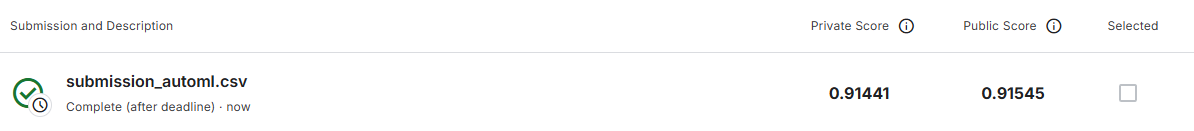

## Вывод:

AutoML прекрасный инструмент для работы, он получил немного лучший результат, чем наш пайплайн, но при этом кол-во усилий минимально

Он экономит время на подборе параметров, протестировал несколько моделей => с него можно быстро стартовать и получить сильный бейзлайн

Что интересно, у AutoML LGBM обогнал XGB